---
# <h1 style="color:olive;"><b>1 - Library</b></h1>

In [ ]:
#!pip install opencv-python numpy face_recognition face_recognition_models scikit-image deepface mediapipe

In [ ]:
#!pip install matplotlib diffusers transformers accelerate safetensors torch pillow datasets

In [ ]:
#!pip install facenet-pytorch retina-face dlib

In [ ]:
'''!pip uninstall diffusers torch torchvision torchaudio -y
!pip cache purge
!pip install torch torchvision torchaudio
!pip install diffusers==0.35.2'''

In [1]:
!python --version

Python 3.10.1


In [15]:
import argparse
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import face_recognition
import torch
import pandas as pd
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image

#from GetFaceFunc import (get_subset_from_zip, abv_avg_quality_randomizer)
#from FaceColorFunc import (get_face_mask, shift_skin_color, change_face_color)
from EvalFace import FaceDetected, close_face_detectors
from Analysis import(SingleColComparison, DfComparison, colorShadeComparison, DfColorShade, colorShadeColumn)

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

---

# <h1 style="color:olive;"><b>2 - GET DATASET</b></h1>

## <h2 style="color:olive;"><b>2.1 - Chose Dataset </b></h2>

When working with computer vision models that process human faces, it is essential to acknowledge the ethical considerations of using people’s images. Facial data is inherently personal and sensitive, and misuse can affect individual privacy and social fairness. Research and applications should respect consent, avoid reinforcement of harmful stereotypes, and be transparent about how data is sourced and used. In the context of algorithmic bias research, these concerns are especially critical; models that perform differently across demographic groups can inadvertently perpetuate inequity if deployed without careful evaluation and mitigation.

Several publicly available face datasets have been created to support research in recognition, alignment, and attribute analysis. Examples include **UTKFace**, which contains a wide range of ages with rough annotations for age, gender, and race; **VGGFace2**, a large collection of identities used for training high-capacity recognition models; and **DiF** (Diversity in Faces), which focuses on granular facial characteristics. Each of these datasets has strengths and limitations: some are extensive but imbalanced across demographic groups, others provide rich annotations but lack uniform preprocessing. For a research project comparing model behavior across pigmentation and detection performance, it is important to balance dataset quality, demographic representation, and practical considerations such as storage and annotation consistency.

During dataset selection, **UTKFace** was considered due to its broad age and race labels. However, UTKFace proved challenging in practice: many images contained misclassified attributes or poor quality labels, and the size of the full dataset made it cumbersome for prototyping and reproducible experimentation. After evaluating multiple alternatives, the **FairFace** dataset was chosen as the primary source for experimental images. *FairFace* was introduced in the work [FairFace: Face Attribute Dataset for Balanced Race, Gender, and Age (Kärkkäinen and Joo, WACV 2021)](https://openaccess.thecvf.com/content/WACV2021/papers/Karkkainen_FairFace_Face_Attribute_Dataset_for_Balanced_Race_Gender_and_Age_WACV_2021_paper.pdf), and was explicitly designed to provide a balanced representation across race, gender, and age subgroups. By mitigating skew in demographic distribution, FairFace supports more equitable evaluation of model performance and reduces confounds related to dataset bias. Its curated and aligned images make it suitable for controlled experiments in facial analysis and bias measurement.

## <h2 style="color:olive;"><b>2.2 - Import Dataset </b></h2>

The FairFace dataset is distributed through the HuggingFace `datasets` library and is organized as a `DatasetDict` with predefined training and validation splits. Each split contains face images alongside demographic annotations that are relevant for fairness-oriented analysis. In this project, the dataset structure enables systematic comparison of facial recognition behavior across demographic groups while maintaining a clear separation between training and evaluation data.

The dataset is structured as follows:

```text
DatasetDict({
    train: Dataset({
        features: ['image', 'age', 'gender', 'race', 'service_test'],
        num_rows: 86744
    })
    validation: Dataset({
        features: ['image', 'age', 'gender', 'race', 'service_test'],
        num_rows: 10954
    })
})


Each row contains an aligned facial image and a set of categorical attributes:

- *image*: RGB face image (PIL format, size 224×224)

- *age*: age group label:
    - **0**: 0–2

    - **1**: 3–9

    - **2**: 10–19

    - **3**: 20–29

    - **4**: 30–39

    - **5**: 40–49

    - **6**: 50–59

    - **7**: 60–69

- *gender*: binary label:
    - **0**: Male

    - **1**: Female

- *race*: categorical race label:

    - **0**: East Asian

    - **1**: Indian

    - **2**: Black

    - **3**: White

    - **4**: Middle Eastern

    - **5**: Latino / Hispanic

    - **6**: Southeast Asian

- *service_test*: boolean flag indicating images reserved for service-level evaluation

The dataset is loaded using the HuggingFace identifier [HuggingFaceM4/FairFace](https://huggingface.co/datasets/HuggingFaceM4/FairFace), which provides multiple resolution variants. Two commonly used variants are:

| Variant  | Meaning                                     | Typical use                                     |
| -------- | ------------------------------------------- | ----------------------------------------------- |
| *"1.25"* | **Higher-resolution images** (larger scale) | Better visual detail, higher accuracy potential |
| *"0.25"* | **Lower-resolution images** (downscaled)    | Faster training, lower memory usage             |


For this project, the "0.25" variant was selected to reduce computational overhead and storage requirements while preserving sufficient facial detail for detection-based experiments.

In [16]:
from datasets import load_dataset

dataset = load_dataset("HuggingFaceM4/FairFace", "0.25")

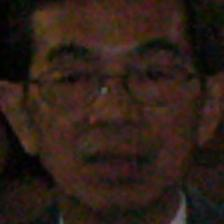

In [ ]:
#Test 
face_foto = dataset['train'][0]['image']
face_foto

In [ ]:
def pil_to_rgb_np(img_pil, style = "RGB"):
    """
    Converts PIL Image to NumPy uint8 array in the requested color style
    (e.g., 'RGB', 'L', 'RGBA').
    """
    return np.array(img_pil.convert(style))

face_foto_rgb = pil_to_rgb_np(face_foto)
face_foto_bgr = cv2.cvtColor(face_foto_rgb, cv2.COLOR_RGB2BGR)

---

# <h1 style="color:olive;"><b>3 - FACIAL PAINT</b></h1>

## <h2 style="color:olive;"><b>Alter Skin Pigmentation</b></h2> 


1-> creating a second img (mask) with only the skin and every other pixel as 0,0,0, than, (to get the this I was thinking of using something like Mediapipe Face Mesh (from Google), BiSeNet for face parsing, DeepLab / U²-Net for general segmentation) 

2-> in the mask, shift the pixels towords the color chosen (maby do like a vector with the lightes pixel to the chosen green and than apply that same vector onto the rest of the pixels getting various shades of green acording to the diference on the light/shade) I don't know if vectors are a good way, I dont know how colour shifts work, if not by matrix than get the most comon pixel colour of the skin as the chosen colour, and the diviations of the other like being darker or slightly more red become something like a darker green or a more yellowish green

*if you work in Lab color space, the hue/lightness balance will stay more realistic than raw RGB.*

3-> afterwards fuse the two, swap the 0,0,0 with values of the mask with values from the same position from the img

| Step            | Feasibility            | Comment                             |
| --------------- | ---------------------- | ----------------------------------- |
| 1. Segmentation | ✅ Very feasible        | Use BiSeNet or Mediapipe.           |
| 2. Color shift  | ✅ Feasible and elegant | Work in Lab space for best results. |
| 3. Fusion       | ✅ Easy                 | Use alpha blending with mask.       |


In [2]:
test_face_c= "../Color_Change" #where to store the imgs
os.makedirs(test_face_c, exist_ok=True)

# ------- FOR NOW TEST 1 IMG --------- #

img_path = "../UTK_filtered/white/29_0_0_20170109002204936.jpg.chip.jpg"#28_0_0_20170104202019890.jpg.chip.jpg 
img_bgr = cv2.imread(img_path)
if img_bgr is None:
    raise ValueError(f"Could not read image from {img_path}")

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
padded = cv2.copyMakeBorder(img_rgb, 40, 40, 40, 40, cv2.BORDER_REFLECT)


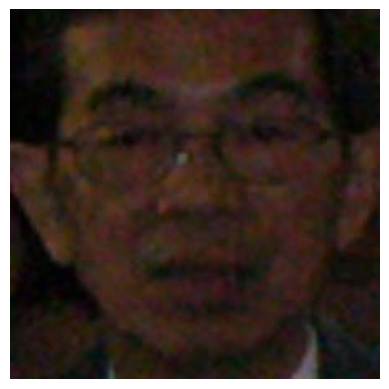

In [13]:
plt.imshow(face_foto_rgb) #img_rgb  #padded cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.show()

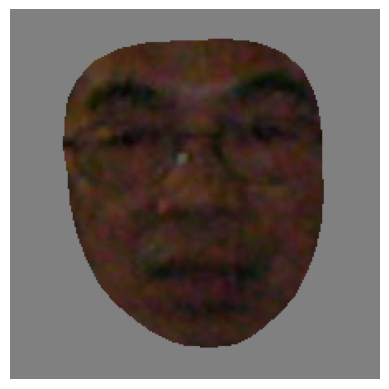

In [14]:
masked_face = get_face_mask(face_foto_rgb)
#print(masked_face)
plt.imshow(masked_face)
plt.axis("off")
plt.show()

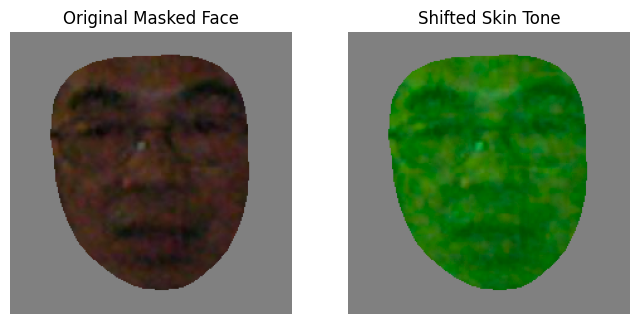

In [44]:
colored_face_mask, _ = shift_skin_color(masked_face, (0,110,0))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(masked_face); plt.title("Original Masked Face"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(colored_face_mask); plt.title("Shifted Skin Tone"); plt.axis("off")
plt.show()

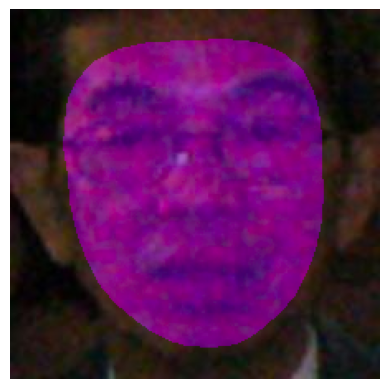

In [45]:
oainted_face = change_face_color(face_foto_bgr, (128, 0, 128)) #img_bgr
plt.imshow(oainted_face)
plt.axis("off")
plt.show()

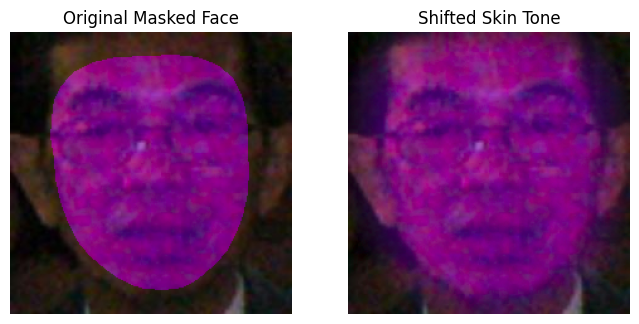

In [46]:
oainted_face = change_face_color(face_foto_bgr, (128, 0, 128))
oainted_face_blur = change_face_color(img = face_foto_bgr, color = (128, 0, 128), smooth = 15)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(oainted_face); plt.title("Original Masked Face"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(oainted_face_blur); plt.title("Shifted Skin Tone"); plt.axis("off")
plt.show()

Problem -> too diff

option 1 (lazy) -> for all images, both normal and altered use only the mask of recognizable face, find the mean of the pixels colors and shift it a little to grey, use this new one as background

option 2 (not so easy) -> the pixels close and on the borderlines gets teir colours mixed. Mimiking a little what the kernel on the CNNs does but applied only on the borders of the face 

| Option                       | Description              | Quality      | Speed   | Complexity | Best For           |
| ---------------------------- | ------------------------ | ------------ | ------- | ---------- | ------------------ |
| 1️⃣ Background harmonization | Shift background color   | 🟡 Medium    | ⚡ Fast  | 🟢 Easy    | Quantitative tests |
| 2a️ Gaussian feather        | Soft transition edges    | 🟢 High      | ⚡ Fast  | 🟢 Easy    | All-rounder        |
| 2b️ Distance fade           | Control fade width       | 🟢 High      | ⚡ Fast  | 🟡 Medium  | Custom look        |
| 2c️ Poisson clone           | Gradient-level blending  | 🟣 Excellent | 🐢 Slow | 🔴 Hard    | Visual realism     |
| 3️⃣ Lightness matching       | Adjust L channel locally | 🟢 High      | ⚡ Fast  | 🟡 Medium  | Natural look       |


In [ ]:
"""
This method takes too much time
...and faild first try
"""

import torch
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image

# load the pretrained Stable Diffusion 2.1 model
model_id = "stabilityai/stable-diffusion-2-1"
device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
).to(device)


# open your input image (replace with your file path)
img_path = "../UTK_filtered/white/29_0_0_20170109002204936.jpg.chip.jpg"#28_0_0_20170104202019890.jpg.chip.jpg 
init_image = Image.open(img_path).convert("RGB")

# the creative prompt
prompt = "the same person but with natural looking green skin, realistic lighting, detailed skin texture, cinematic portrait"

# adjust strength: 0.3–0.6 = subtle; 0.7+ = big change
result = pipe(
    prompt=prompt,
    image=init_image,
    strength=0.5,
    guidance_scale=8.0
).images[0]

#result.save("green_skin_output.png")
#print("✅ Saved output to green_skin_output.png")

plt.imshow(result)
plt.axis("off")
plt.show()


c:\Users\Daniela\Desktop\Fac\M.IA\ano_1\semestre_1\IAS\Projeto_Individual\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Daniela\.cache\huggingface\hub\models--stabilityai--stable-diffusion-2-1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading pipeline components...:  17%|█▋        | 1/6 [

: 

| Goal                                 | Method                              | Function                     |
| ------------------------------------ | ----------------------------------- | ---------------------------- |
| Rough face box                       | `face_recognition.face_locations()` | Rectangle mask               |
| Detailed outline                     | `face_recognition.face_landmarks()` | Polygon mask (jawline, etc.) |
| True pixel mask (skin vs background) | Mediapipe / segmentation model      | Requires external library    |


| Method                     | Type                  | Accuracy                                                    | Speed       | Comments                                            |
| -------------------------- | --------------------- | ----------------------------------------------------------- | ----------- | --------------------------------------------------- |
| **Mediapipe Face Mesh**    | Landmark-based        | ✅ Good for face contours, eyes, lips                        | ⚡ Very fast | Doesn’t explicitly label “skin” vs “hair”           |
| **BiSeNet (Face Parsing)** | Semantic segmentation | ⭐ Excellent — directly gives skin, eyes, mouth, hair labels | 🐢 Slower   | Requires model weights, but great for research      |
| **U²-Net / DeepLab**       | General segmentation  | Medium                                                      | Medium      | Not face-specific — can confuse hair and background |


### <h2 style="color:olive;"><b>3.1 Chose color palet</b></h2>

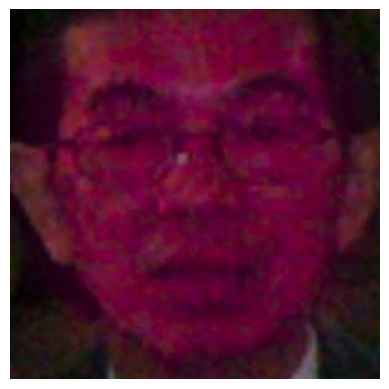

In [10]:
#Test set -> visually analyse color of choosing

oainted_face_blur = change_face_color(img = face_foto_bgr, color = (102, 0, 51), smooth = 15)
plt.imshow(oainted_face_blur)
plt.axis("off")
plt.show()

In [6]:
#(102, 51, 0), #orange
#(51, 25, 0), # orange dark

palet = [
    ("Red", (102, 0, 0), "light"), # Red
    ("Red", (51, 0, 0), "dark"), # Red, dark 
    ("yellow", (102, 102, 0), "light"), # yellow
    ("yellow", (51, 51, 0), "dark"), # yellow dark
    ("green", (0, 102, 0), "light"), # green
    ("green", (0, 51, 0), "dark"), # green dark
    ("blue", (0, 102, 102), "light"), # blue (mix)
    ("blue", (0, 51, 51), "dark"), # blue (mix) dark
    ("indigo", (0, 0, 102), "light"), # indigo
    ("indigo", (0, 0, 51), "dark"), # indigo dark
    ("roxo", (102, 0, 102), "light"), #roxo
    ("roxo", (51, 0, 51), "dark"), #roxo dark
    ]


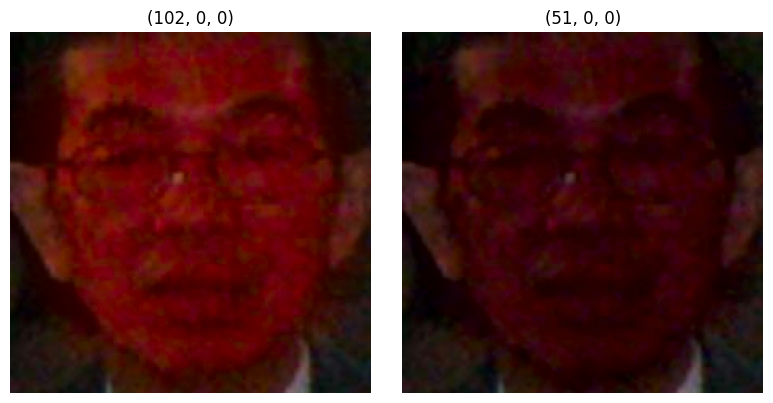

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for ax, p in zip(axes, palet[:2]):
    painted = change_face_color(
        img=face_foto_bgr,
        color=p,
        smooth=15
    )
    ax.imshow(painted)
    ax.set_title(str(p))
    ax.axis("off")

plt.tight_layout()
plt.show()


---
# <h1 style="color:olive;"><b> 4 - Facial Recogniton</b></h1>

<h3><b>Overvew:</b></h3>

Several Face Recognition Models will be tested to check how different training sets can influence unseen skin characteristics

The models to be testes are:
- MediaPipe;          “Balanced-ish” (≈ FairFace)
- MTCNN Mixed;        (≈ UTK / DiF)
- RetinaFace;         VGGFace2-like
- Dlib HOG;           Biased baseline

This where trained with differently balanced dfs:
- FairFace (most balanced df)
- UTK (not as balanced but the second lowes rate of whites, small race division)
- DiF (simmilar to UTK but with more 'race' variety)
- VGG2 (higly unbalanced)

the results will be stored in a df
columns
| COLUMNS                                 | DESCRIPTION                              | 
| ------------------------------------ | ----------------------------------- | 
| id | simmilar to the og imgs id but with new sufix of the faces color |
| old_img_id | the base imgs id |
| age | the age of the person in the foto |
| sex | the sex (male, female) |
| race | the og mg defined race |
| color | the new color of the individuals face |
| shade | lighter shade of color or darker shade |
| FR_model | the face recognition model used |
| y | the resuts of the given img by the chosen FR_model |


do per model 
- for same colour but diff tonalities
- check the diff clours toghether 
- compare lighter and darker tones
- compare same colours but different races

off all models 
- check ability to predict

In [7]:
oainted_face_blur = change_face_color(img = face_foto_bgr, color = (128, 0, 128), smooth = 15)
print(FaceDetected(face_foto_bgr))
print(FaceDetected(oainted_face_blur))


[True, True, True]
[True, True, True]


In [ ]:
FR_list = ["mediapipe", "dlib_hog", "mtcnn"]

rows = []

start_idx = 13336
stop_idx = 50000
subset = dataset["train"].select(range(start_idx, stop_idx))
#for idx, row in enumerate(dataset["train"][start_idx:], start=start_idx): #dataset["train"]

for idx, row in enumerate(subset, start=start_idx):
    print(f"curr id =\n ---> {idx}")

    base_id = idx
    age = row["age"]
    sex = row["gender"]     
    race = row["race"]

    face_foto_rgb = pil_to_rgb_np(row["image"])
    face_foto_bgr = cv2.cvtColor(face_foto_rgb, cv2.COLOR_RGB2BGR)

    for color_name, color_rgb, shade in palet:
        painted_face = change_face_color(
            img=face_foto_bgr,
            color=color_rgb,
            smooth=15
        )

        if painted_face is None:
            continue

        detections = FaceDetected(painted_face, FR_list)

        rows.append({
            "id": f"{base_id}_{color_name}_{shade}",
            "old_img_id": base_id,
            "age": age,
            "sex": sex,
            "race": race,
            "color": color_name,
            "shade": shade,
            f"y_{FR_list[0]}": int(detections[0]),
            f"y_{FR_list[1]}": int(detections[1]),
            f"y_{FR_list[2]}": int(detections[2]),
        })
 
close_face_detectors()


In [10]:
df = pd.DataFrame(rows)
print(df.head())

               id  old_img_id  age  sex  race   color  shade  y_mediapipe  \
0     0_Red_light           0    6    0     0     Red  light            1   
1      0_Red_dark           0    6    0     0     Red   dark            1   
2  0_yellow_light           0    6    0     0  yellow  light            1   
3   0_yellow_dark           0    6    0     0  yellow   dark            0   
4   0_green_light           0    6    0     0   green  light            0   

   y_dlib_hog  y_mtcnn  
0           1        1  
1           0        1  
2           1        1  
3           1        1  
4           1        0  


In [ ]:
print(df.iloc[-1])

id             13335_Red_dark
old_img_id              13335
age                         1
sex                         0
race                        2
color                     Red
shade                    dark
y_mediapipe                 1
y_dlib_hog                  1
y_mtcnn                     1
Name: 149101, dtype: object


In [17]:
i = 13335
for i in range(13335,13339):
    print(i)

13335
13336
13337
13338


In [11]:
df.to_csv("face_detection_results.csv", index=False)

In [21]:
def usedIDs(df: pd.DataFrame):
    """
    Returns:
        used_ids: sorted list of dataset indices that appear in df
        missing_ids: sorted list of dataset indices missing between min and max
    """
    used_ids = sorted(df["old_img_id"].unique())

    min_id = used_ids[0]
    max_id = used_ids[-1]

    full_set = set(range(min_id, max_id + 1))
    used_set = set(used_ids)

    missing_ids = sorted(full_set - used_set)

    return used_ids, missing_ids



FR_list = ["mediapipe", "dlib_hog", "mtcnn"]
start_idx = 0
stop_idx = 13335

ids, missing_ids = usedIDs(df_2)
print(f"missing ids list = {missing_ids}")

rows = []

for i in ids:  # ids must be dataset indices
    row = dataset["train"][i]
    print(i)

    face_foto_rgb = pil_to_rgb_np(row["image"])

    detections = FaceDetected(face_foto_rgb, FR_list)

    rows.append({
        "old_img_id": i,
        "age": row["age"],
        "sex": row["gender"],
        "race": row["race"],
        f"y_{FR_list[0]}": int(detections[0]),
        f"y_{FR_list[1]}": int(detections[1]),
        f"y_{FR_list[2]}": int(detections[2]),
    })

close_face_detectors()

'''
for i in ids: #range(start_idx, stop_idx, 12):
    new = print(df["old_img_id"].iloc[i])
    #print(dataset["train"][i]["gender"])
    row = dataset["train"][i]
    face_foto_rgb = pil_to_rgb_np(row["image"])
    #face_foto_bgr = cv2.cvtColor(face_foto_rgb, cv2.COLOR_RGB2BGR)

    detections = FaceDetected(face_foto_rgb, FR_list)

    rows.append({
            "old_img_id": df["old_img_id"].iloc[i],
            "age": row["age"],
            "sex": row["gender"],
            "race": row["race"],
            f"y_{FR_list[0]}": int(detections[0]),
            f"y_{FR_list[1]}": int(detections[1]),
            f"y_{FR_list[2]}": int(detections[2]),
        })
    gap = new-old
    if gap>1:
        print(f'gap = {gap}')
    old = print(df["old_img_id"].iloc[i])
close_face_detectors()
'''

missing ids list = [13358, 13363, 13371, 13382, 13395, 13397, 13419, 13434, 13447, 13465, 13468, 13470, 13473, 13500, 13515, 13552, 13563, 13564, 13591, 13621, 13625, 13631, 13637, 13645, 13675, 13680, 13686, 13716, 13717, 13718, 13723, 13819, 13842, 13850, 13854, 13855, 13861, 13863, 13869, 13875, 13894, 13901, 13941, 13954, 13956, 13979, 14000, 14011, 14025, 14054, 14073, 14078, 14092, 14102, 14144, 14169, 14184, 14185, 14219, 14222, 14264, 14265, 14270, 14278, 14301, 14312, 14315, 14318, 14320, 14324, 14354, 14355, 14359, 14396, 14401, 14445, 14449, 14461, 14483, 14497, 14509, 14512, 14526, 14552, 14573, 14582, 14585, 14587, 14624, 14682, 14683, 14741, 14749, 14759, 14773, 14781, 14784, 14795, 14807, 14835, 14838, 14879, 14882, 14890, 14894, 14909, 14936, 14963, 14966, 14971, 14979, 14991, 15001, 15019, 15033, 15050, 15063, 15067, 15080, 15083, 15131, 15133, 15151, 15153, 15191, 15195, 15201, 15203, 15214, 15240, 15268, 15293, 15305, 15318, 15324, 15340, 15345, 15347, 15364, 15374, 

'\nfor i in ids: #range(start_idx, stop_idx, 12):\n    new = print(df["old_img_id"].iloc[i])\n    #print(dataset["train"][i]["gender"])\n    row = dataset["train"][i]\n    face_foto_rgb = pil_to_rgb_np(row["image"])\n    #face_foto_bgr = cv2.cvtColor(face_foto_rgb, cv2.COLOR_RGB2BGR)\n\n    detections = FaceDetected(face_foto_rgb, FR_list)\n\n    rows.append({\n            "old_img_id": df["old_img_id"].iloc[i],\n            "age": row["age"],\n            "sex": row["gender"],\n            "race": row["race"],\n            f"y_{FR_list[0]}": int(detections[0]),\n            f"y_{FR_list[1]}": int(detections[1]),\n            f"y_{FR_list[2]}": int(detections[2]),\n        })\n    gap = new-old\n    if gap>1:\n        print(f\'gap = {gap}\')\n    old = print(df["old_img_id"].iloc[i])\nclose_face_detectors()\n'

In [22]:
df = pd.DataFrame(rows)
print(df.head())

   old_img_id  age  sex  race  y_mediapipe  y_dlib_hog  y_mtcnn
0       13336    3    0     0            1           0        1
1       13337    2    0     3            1           0        1
2       13338    2    0     2            1           0        1
3       13339    3    1     0            1           1        1
4       13340    4    0     5            1           1        1


In [23]:
print(df.iloc[-1])

old_img_id     49998
age                4
sex                0
race               5
y_mediapipe        1
y_dlib_hog         1
y_mtcnn            1
Name: 34289, dtype: int64


In [24]:
df.to_csv("og_face_results_p2.csv", index=False)

---
# <h1 style="color:olive;"><b>5 - Results Analysis </b></h1>

this part is for analysis of the results_df, it's purpose is to visualize how the diferent colors impacted the facial recognition networks, what colors have hiher fail rate, define how much the models depend on color to identify faces (if all people have same facial color is there still a diference in accoracy between races? and if so is it the same, smaller or greater? is there a diference between same untrained colors but different sexes? does color have diferent impacts in differen age groups?)

## <h2 style="color:olive;"><b>5.1 - DataSet Cleaning </b></h2>

In [20]:
df_1 = pd.read_csv("face_detection_results.csv")
df_2 = pd.read_csv("face_detection_results_p2.csv")
df_3 = pd.read_csv("og_face_results.csv")


alter some of the columns values so as to make them more understandable when analysing

In [3]:

d_sex={0: 'Male',
       1: 'Female'}
d_race={0: 'East_Asian',
        1: 'Indian',
        2: 'Black',
        3: 'White',
        4: 'Middle Eastern',
        5: 'Latino_Hispanic',
        6: 'Southeast_Asian'}
d_age={0:'0-2',
       1:'3-9',
       2:'10-19',
       3:'20-29',
       4:'30-39',
       5:'40-49',
       6:'50-59',
       7:'60-69',
       }

df_list = [df_1, df_2, df_3]

for df in df_list:
    df['sex'] = df['sex'].map(d_sex)
    df['race'] = df['race'].map(d_race)
    df['age'] = df['age'].map(d_age)



In [4]:
df = pd.concat([df_1, df_2])
print(f"columns={df.columns}\n{df.iloc[-1]}")
df.head()

columns=Index(['id', 'old_img_id', 'age', 'sex', 'race', 'color', 'shade',
       'y_mediapipe', 'y_dlib_hog', 'y_mtcnn'],
      dtype='object')
id             49998_roxo_dark
old_img_id               49998
age                      30-39
sex                       Male
race           Latino_Hispanic
color                     roxo
shade                     dark
y_mediapipe                  1
y_dlib_hog                   0
y_mtcnn                      0
Name: 411479, dtype: object


,id,old_img_id,age,sex,race,color,shade,y_mediapipe,y_dlib_hog,y_mtcnn
0,0_Red_light,0,50-59,Male,East_Asian,Red,light,1,1,1
1,0_Red_dark,0,50-59,Male,East_Asian,Red,dark,1,0,1
2,0_yellow_light,0,50-59,Male,East_Asian,yellow,light,1,1,1
3,0_yellow_dark,0,50-59,Male,East_Asian,yellow,dark,0,1,1
4,0_green_light,0,50-59,Male,East_Asian,green,light,0,1,0


In [5]:
df_1.head()

,id,old_img_id,age,sex,race,color,shade,y_mediapipe,y_dlib_hog,y_mtcnn
0,0_Red_light,0,50-59,Male,East_Asian,Red,light,1,1,1
1,0_Red_dark,0,50-59,Male,East_Asian,Red,dark,1,0,1
2,0_yellow_light,0,50-59,Male,East_Asian,yellow,light,1,1,1
3,0_yellow_dark,0,50-59,Male,East_Asian,yellow,dark,0,1,1
4,0_green_light,0,50-59,Male,East_Asian,green,light,0,1,0


In [6]:
df_3.head()

,old_img_id,age,sex,race,y_mediapipe,y_dlib_hog,y_mtcnn
0,0,50-59,Male,East_Asian,1,1,1
1,1,30-39,Female,Indian,1,1,1
2,2,3-9,Female,Black,1,1,1
3,3,20-29,Female,Indian,1,0,1
4,4,20-29,Female,Indian,1,1,1


## <h2 style="color:olive;"><b>5.2 - Painted vs Original: first comparison </b></h2>

### try with all info - Alter the txts

### <h3 style="color:olive;"><b>5.2.1 - Race </b></h3>

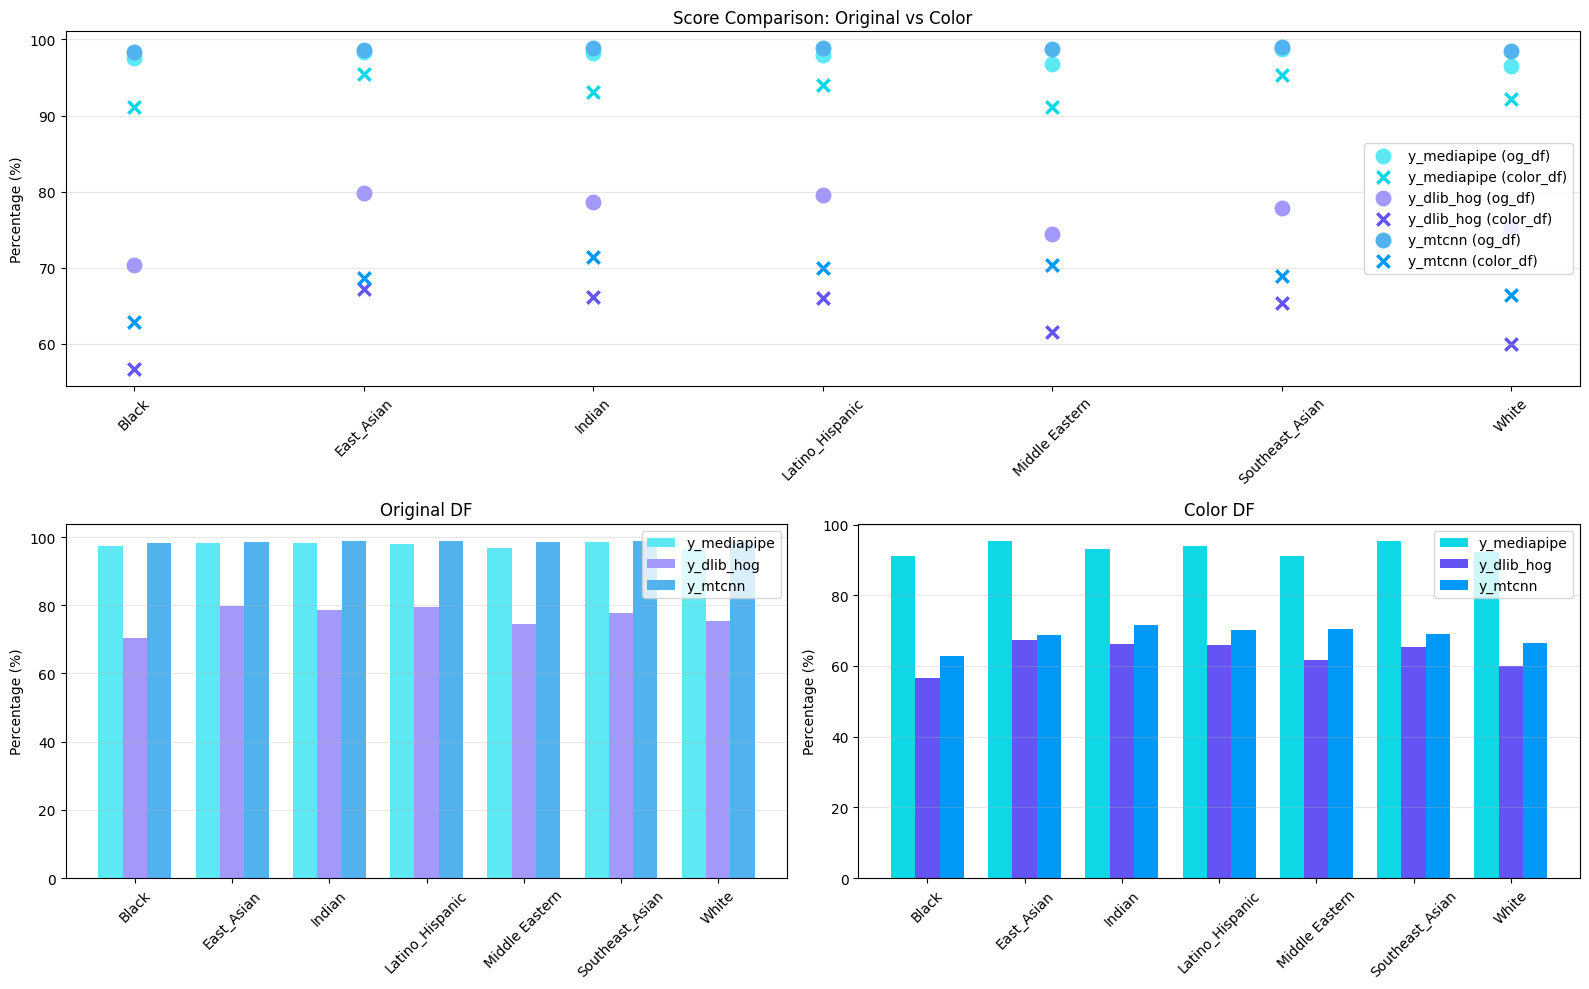

,race,y_mediapipe_og,y_dlib_hog_og,y_mtcnn_og,y_mediapipe_color,y_dlib_hog_color,y_mtcnn_color,y_mediapipe_diff,y_dlib_hog_diff,y_mtcnn_diff
0,Black,97.506925,70.360111,98.393352,91.182448,56.655889,62.882217,-6.324477,-13.704222,-35.511135
1,East_Asian,98.326601,79.803808,98.672822,95.446240,67.267744,68.691094,-2.880362,-12.536065,-29.981727
2,Indian,98.192090,78.644068,98.870056,93.130885,66.139360,71.464218,-5.061205,-12.504708,-27.405838
3,Latino_Hispanic,97.919838,79.553526,98.833080,94.013191,66.053611,70.040589,-3.906646,-13.499915,-28.792491
4,Middle Eastern,96.751740,74.400619,98.685228,91.144625,61.588038,70.436968,-5.607115,-12.812581,-28.248260
5,Southeast_Asian,98.691956,77.828646,98.953564,95.367342,65.374973,68.912143,-3.324613,-12.453673,-30.041421
6,White,96.516129,75.354839,98.451613,92.132616,59.960573,66.433692,-4.383513,-15.394265,-32.017921


In [7]:
SingleColComparison(df_3, df_1, ['race'])
DfComparison(df_3, df_1, ['race'])

all races were painted the same colors so, provided collor is the only thing that matters, results should be somewhat identicle,
dlib and mtcnn showed simmilar patterns, small discrepencies on the success rate of each race, the most notorious cases where `Middle Eastern` and surprinsingly `White`. 
`East_Asian` was the one that reach the highest detection value (95.63%) secconed by `Southeast_Asian`.
Althogh White was the race that , when training the models was most predominant, none of the models had it as the highest percentual value when with different colors

### <h3 style="color:olive;"><b>5.2.2 - Gender </b></h3>

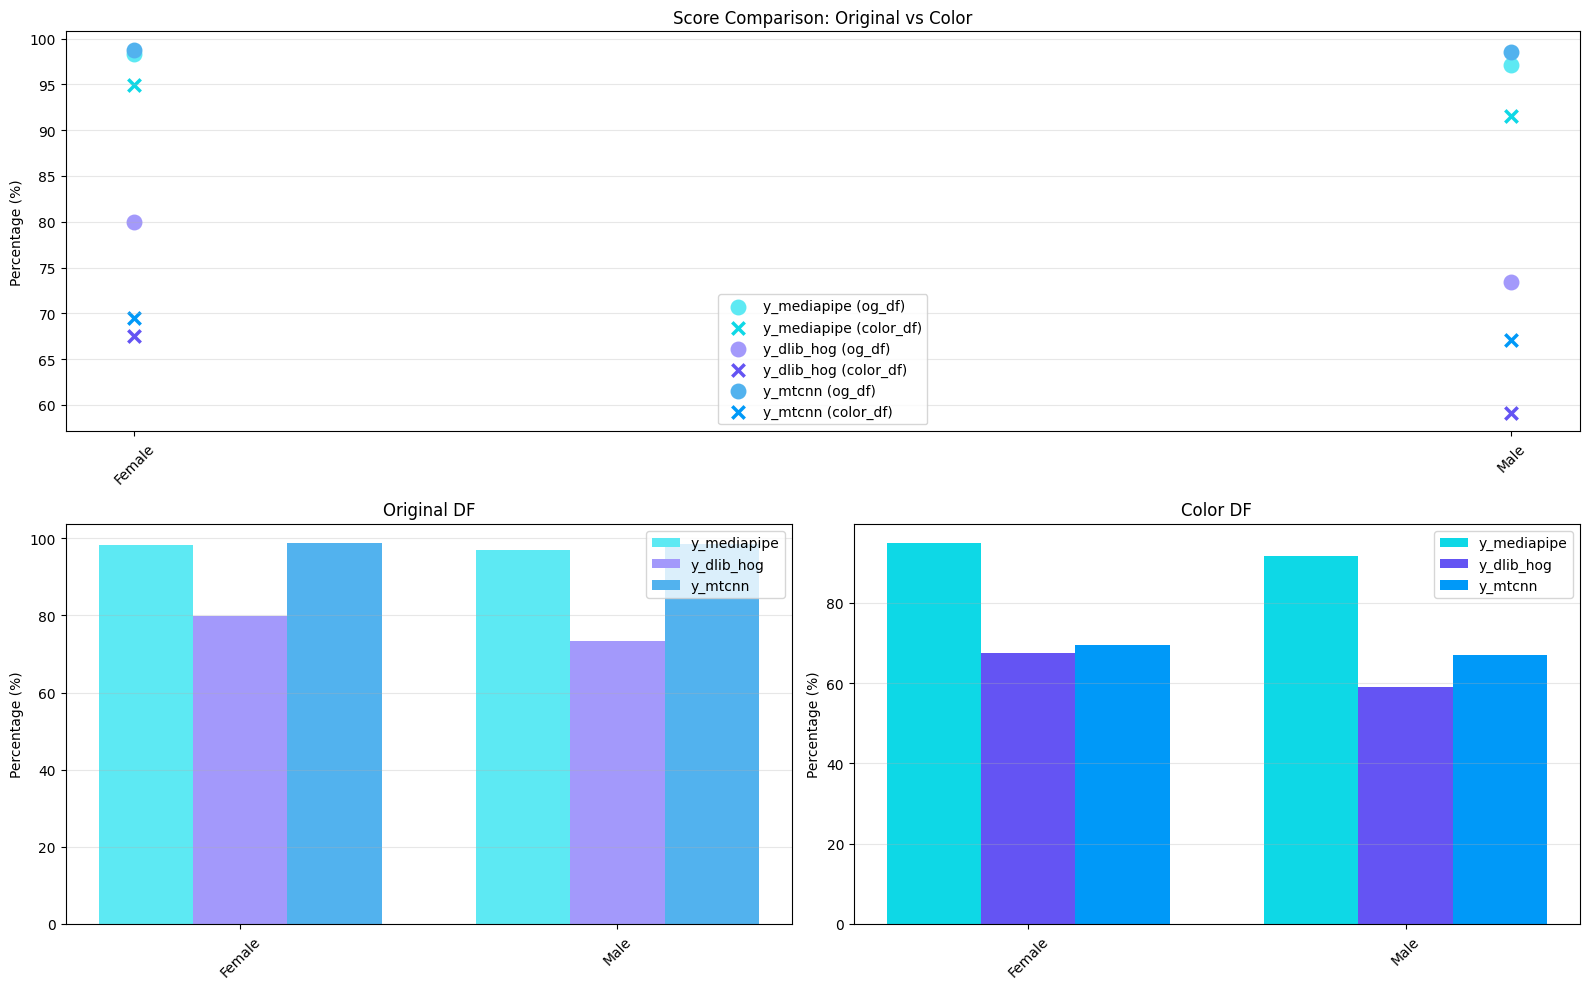

,sex,y_mediapipe_og,y_dlib_hog_og,y_mtcnn_og,y_mediapipe_color,y_dlib_hog_color,y_mtcnn_color,y_mediapipe_diff,y_dlib_hog_diff,y_mtcnn_diff
0,Female,98.298866,79.969980,98.815877,94.934123,67.567267,69.483823,-3.364743,-12.402713,-29.332055
1,Male,97.076205,73.437014,98.553655,91.568373,59.092677,67.086196,-5.507832,-14.344337,-31.467459


In [39]:
SingleColComparison(df_3, df_1, ['sex'])
DfComparison(df_3, df_1, ['sex'])

**Mediapipe** was the only model that was able to obtain a higher score with darker tones.
The lowes score was from **dlib hog** on `dark` and `male` failing almos half of the images (almost 17% lower than its best performer of `light` and `female`)

In general the models have higer success at identifying female faces compared to male ones(compare this results the ones using only normal skin pigmentations)

Interesting note is that dlib hog managed to outperform mtcnn if the image was `female` and `light` skin tone

### <h3 style="color:olive;"><b>5.2.3 - Age </b></h3>

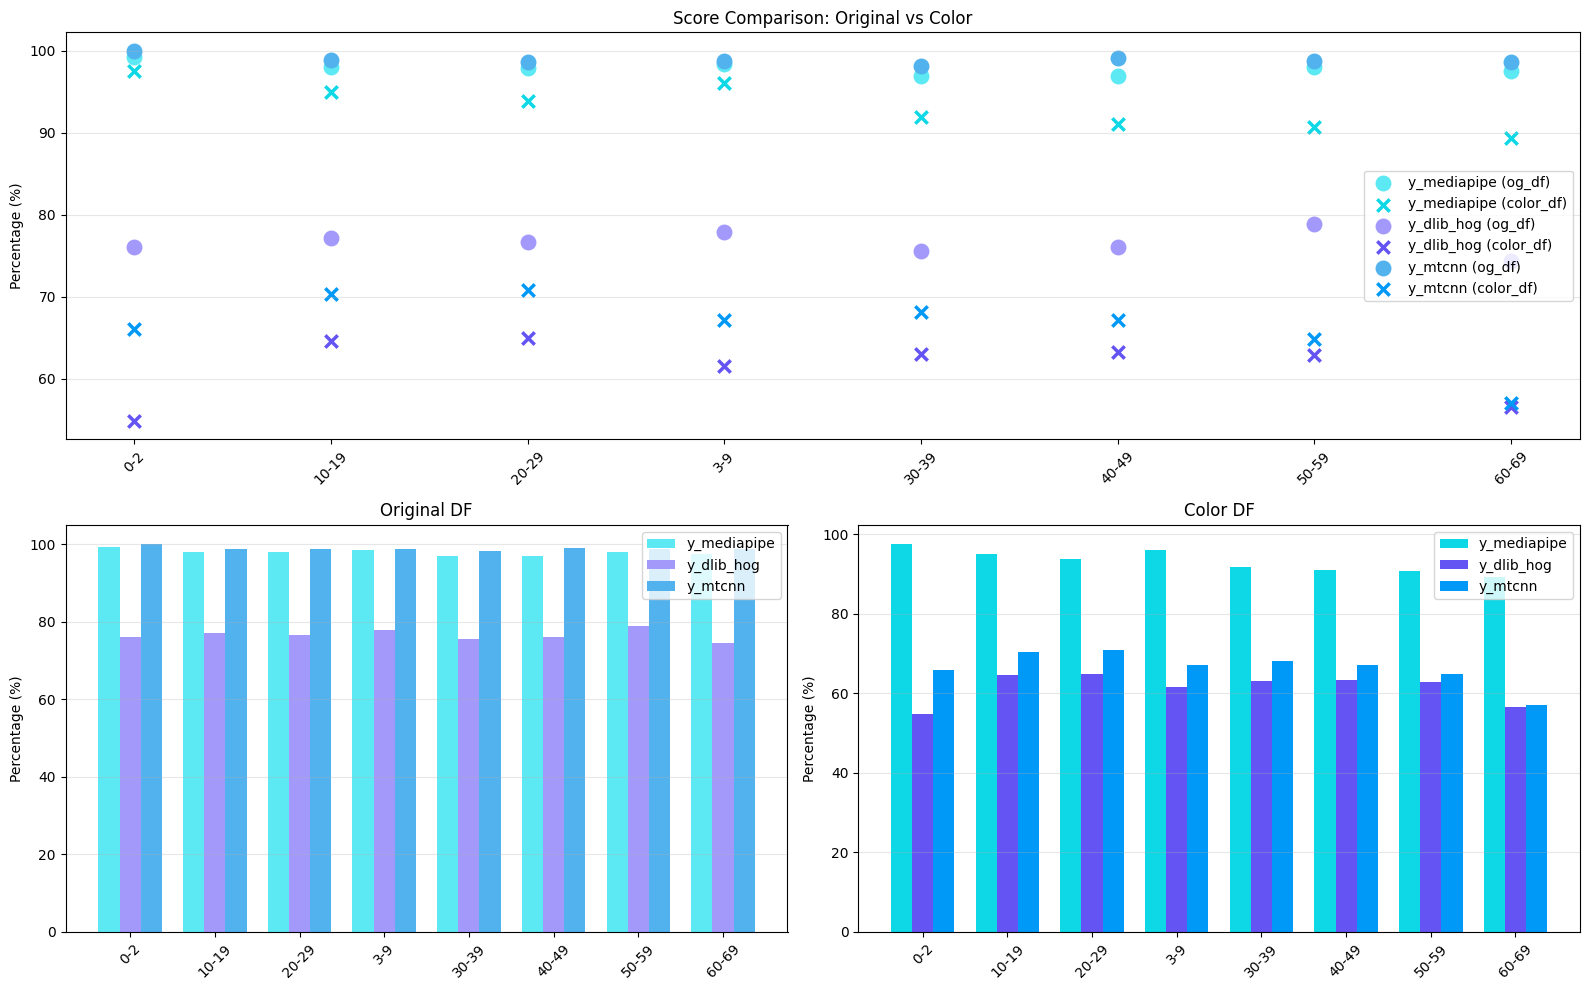

,age,y_mediapipe_og,y_dlib_hog_og,y_mtcnn_og,y_mediapipe_color,y_dlib_hog_color,y_mtcnn_color,y_mediapipe_diff,y_dlib_hog_diff,y_mtcnn_diff
0,0-2,99.264706,76.102941,100.000000,97.549020,54.840686,66.023284,-1.715686,-21.262255,-33.976716
1,10-19,98.043478,77.101449,98.840580,95.036232,64.577295,70.368357,-3.007246,-12.524155,-28.472222
2,20-29,97.869397,76.618705,98.644162,93.884892,64.976480,70.849474,-3.984505,-11.642225,-27.794687
3,3-9,98.404595,77.919592,98.787492,96.030648,61.546238,67.186336,-2.373947,-16.373353,-31.601156
4,30-39,96.949273,75.523235,98.190848,91.897245,63.009933,68.156557,-5.052028,-12.513303,-30.034291
5,40-49,96.971783,76.049553,99.105299,91.047259,63.271393,67.119752,-5.924524,-12.778160,-31.985547
6,50-59,97.985782,78.909953,98.815166,90.728673,62.865324,64.830174,-7.257109,-16.044629,-33.984992
7,60-69,97.574124,74.393531,98.652291,89.308176,56.491465,57.030548,-8.265948,-17.902066,-41.621743


In [40]:
SingleColComparison(df_3, df_1, ['age'])
DfComparison(df_3, df_1, ['age'])

## <h2 style="color:olive;"><b>5.3 - Painted vs Original: how colors and shades change the outcome </b></h2>

### try with all info - Alter the txts

add cols id, color and shade to og_df
fuse the dfs

In [7]:
df_3 = df_3.assign(
    id=df_3["old_img_id"].astype(str) + "_og",
    color="og",
    shade="og"
)

df_fuse = pd.concat([df_1, df_3])
df_fuse = df_fuse.sort_values(by=["old_img_id"])
df_fuse.head()


,id,old_img_id,age,sex,race,color,shade,y_mediapipe,y_dlib_hog,y_mtcnn
0,0_Red_light,0,50-59,Male,East_Asian,Red,light,1,1,1
11,0_roxo_dark,0,50-59,Male,East_Asian,roxo,dark,1,1,1
10,0_roxo_light,0,50-59,Male,East_Asian,roxo,light,1,1,1
9,0_indigo_dark,0,50-59,Male,East_Asian,indigo,dark,0,0,0
8,0_indigo_light,0,50-59,Male,East_Asian,indigo,light,0,0,1


### <h3 style="color:olive;"><b>5.3.1 - Race </b></h3>

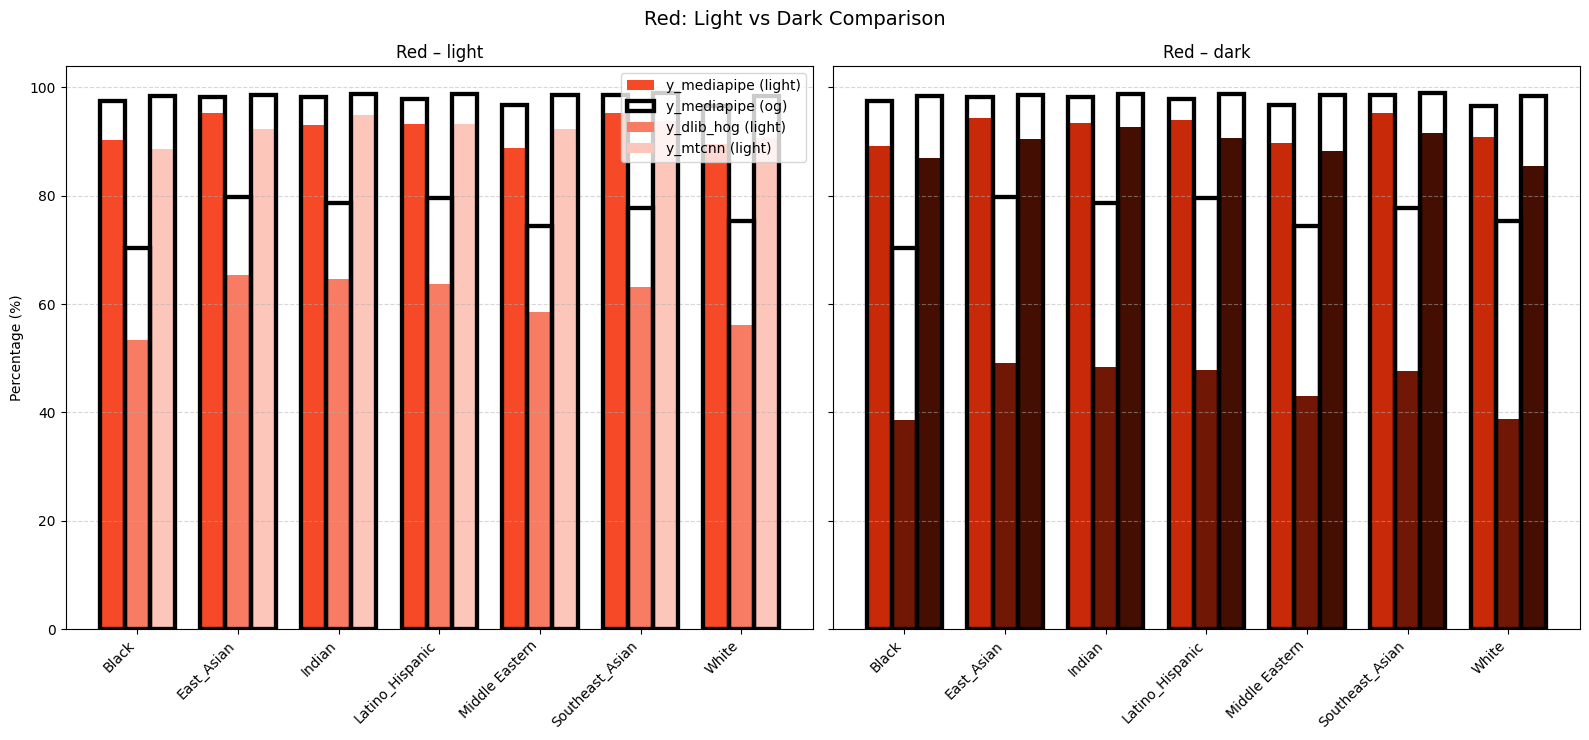

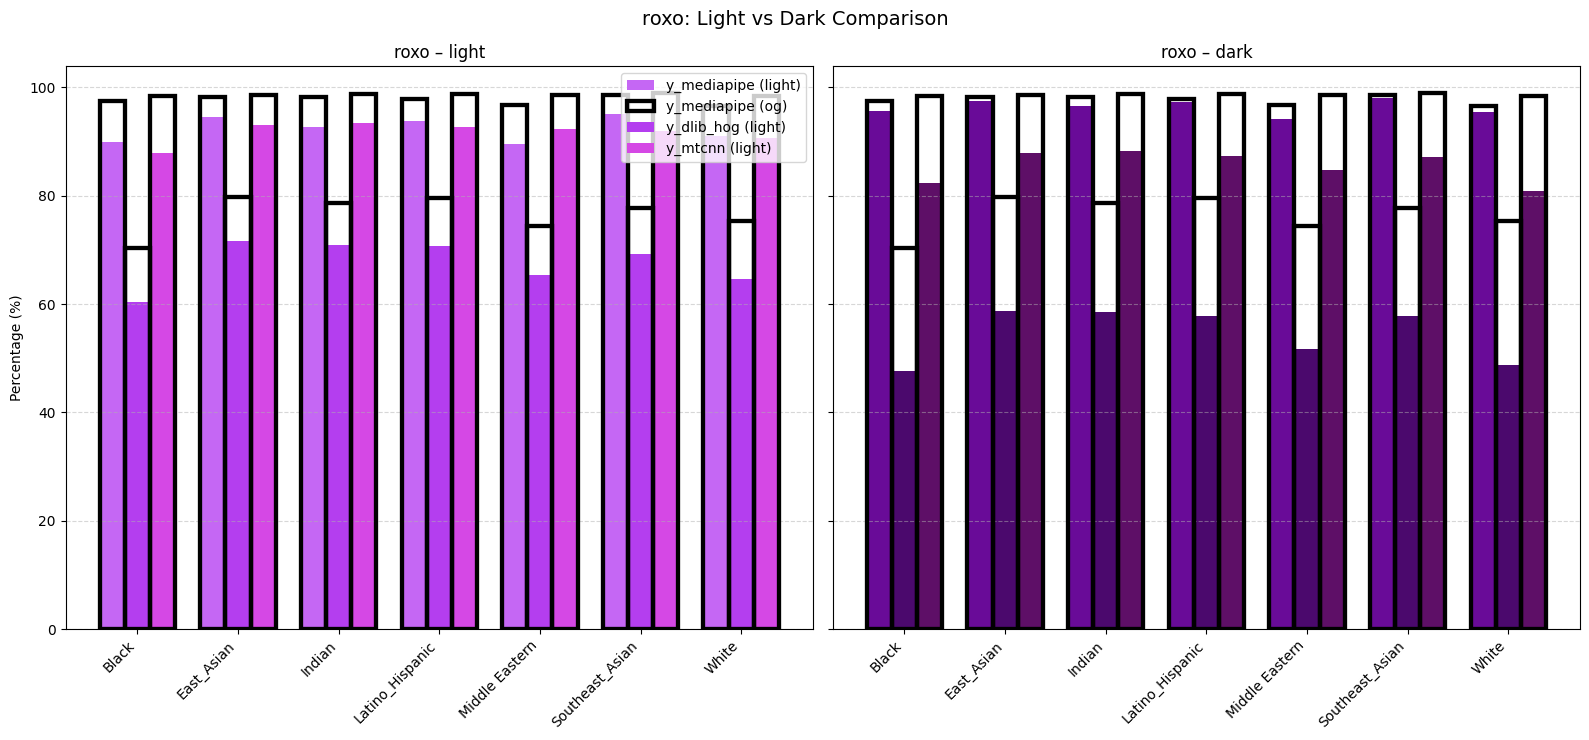

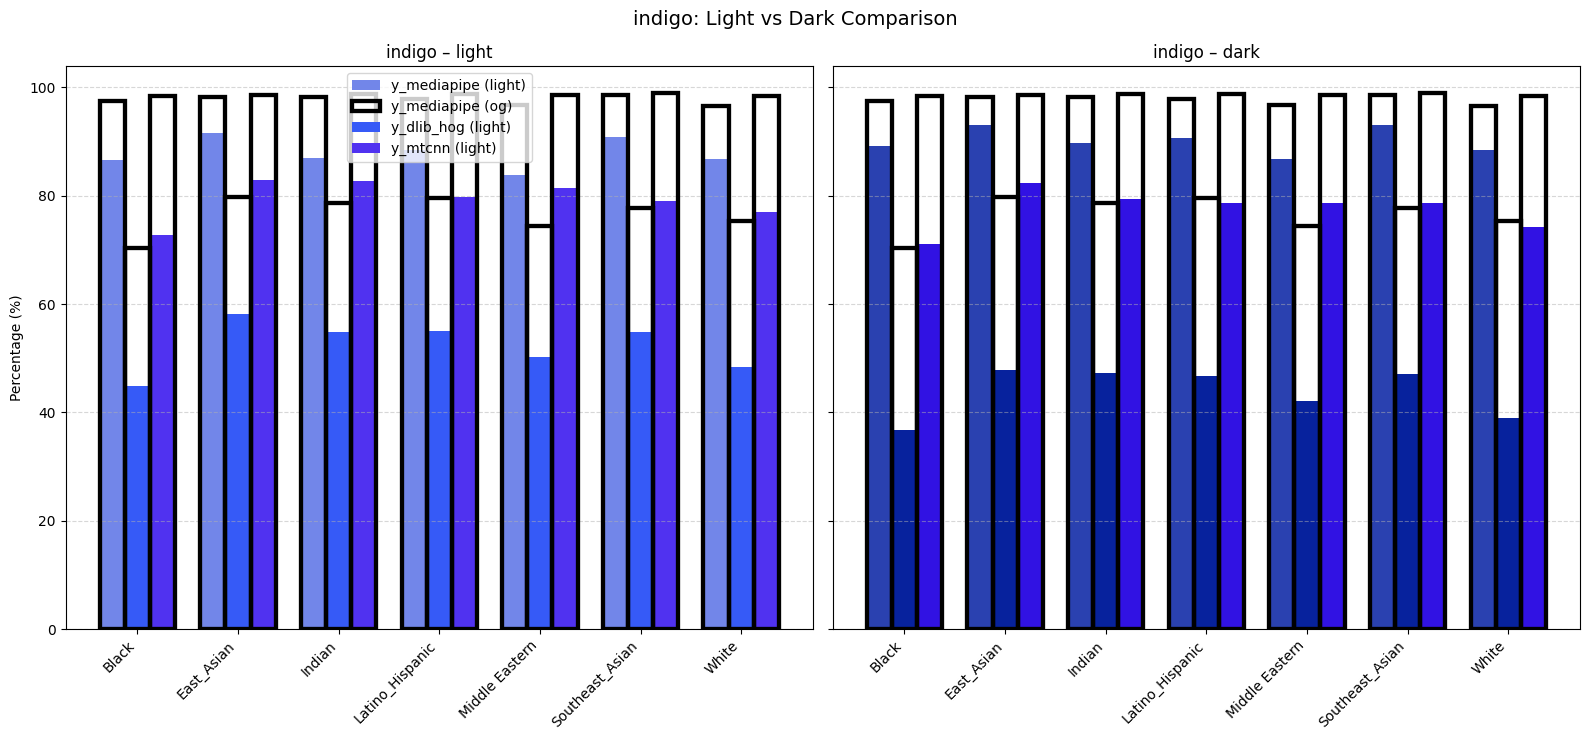

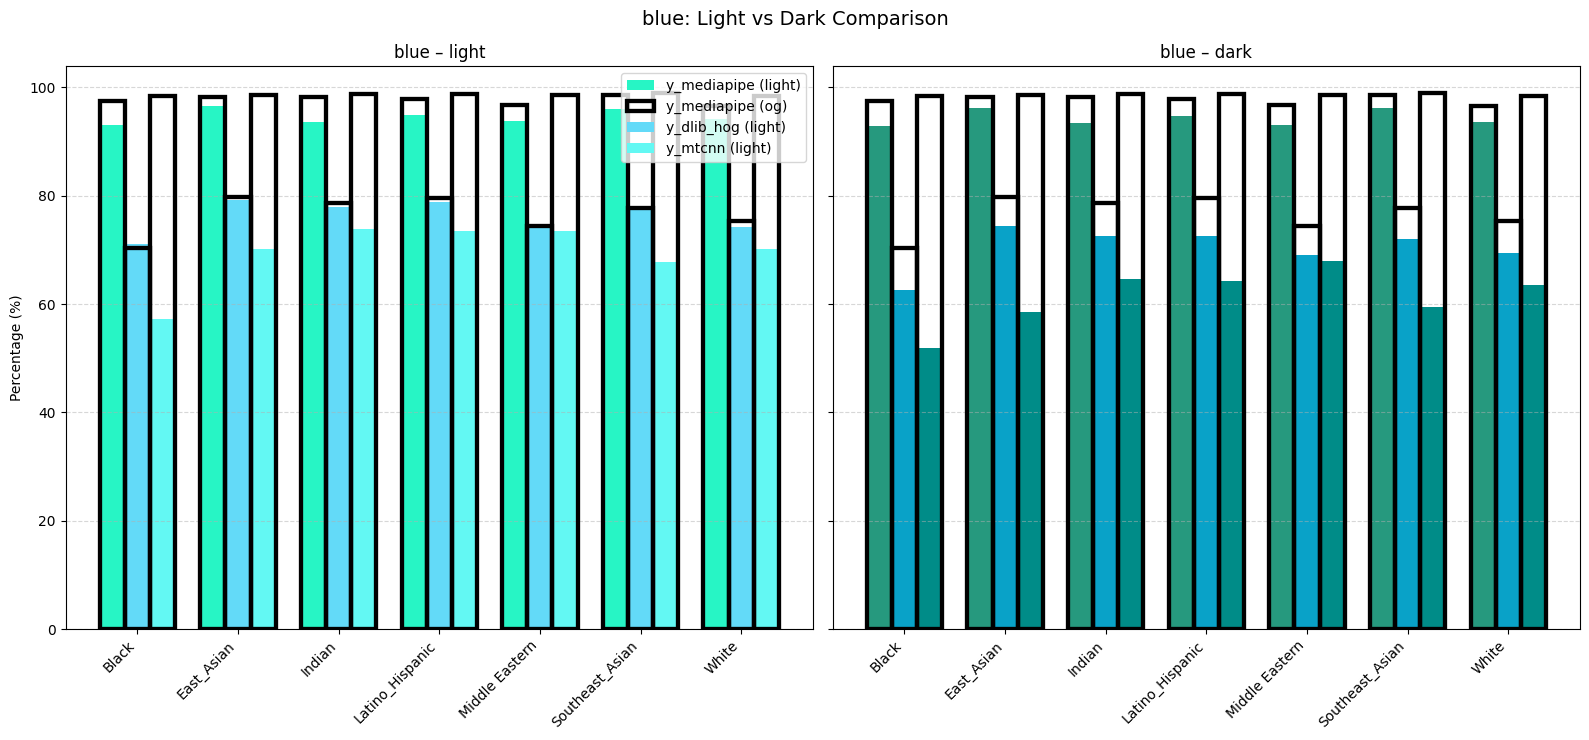

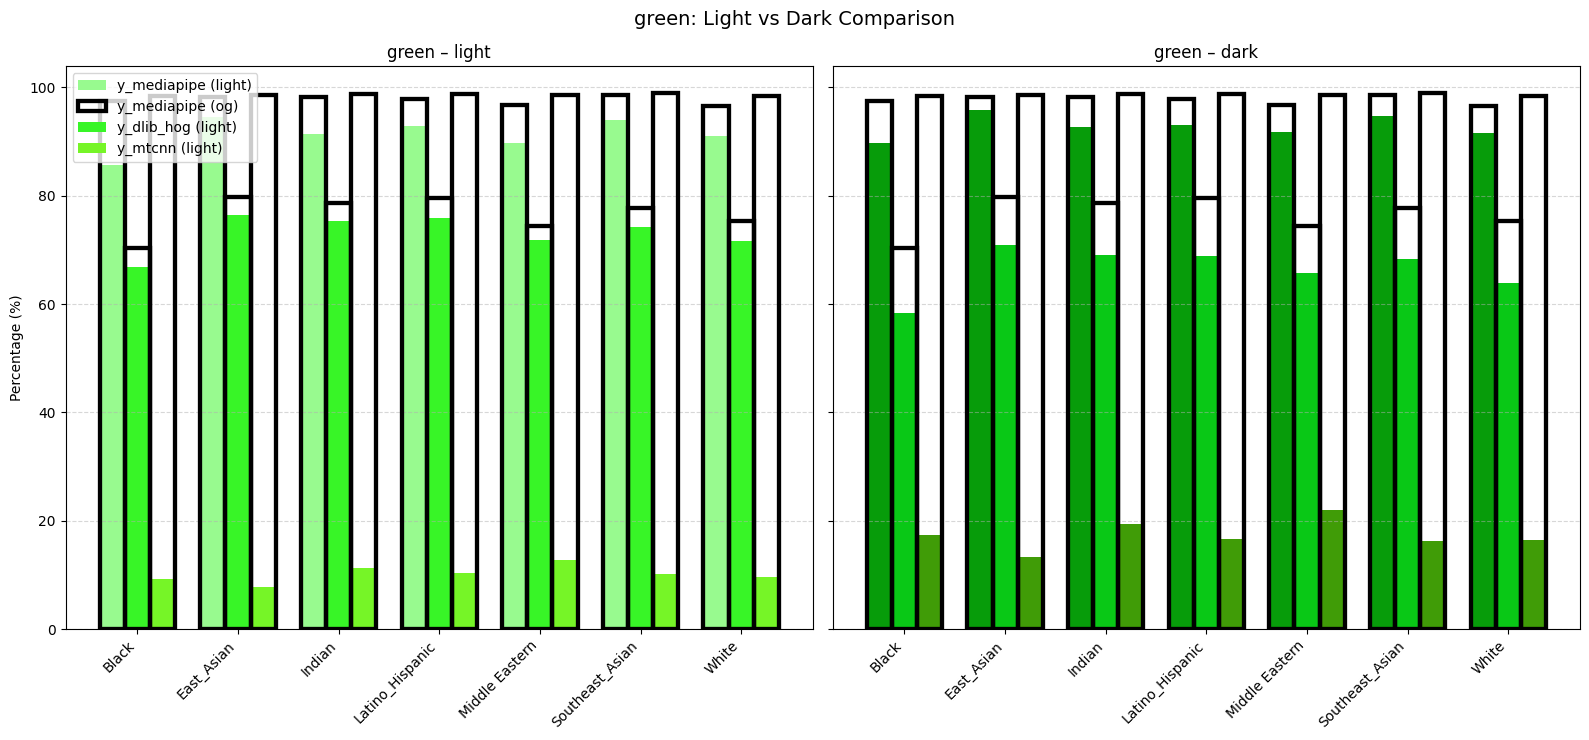

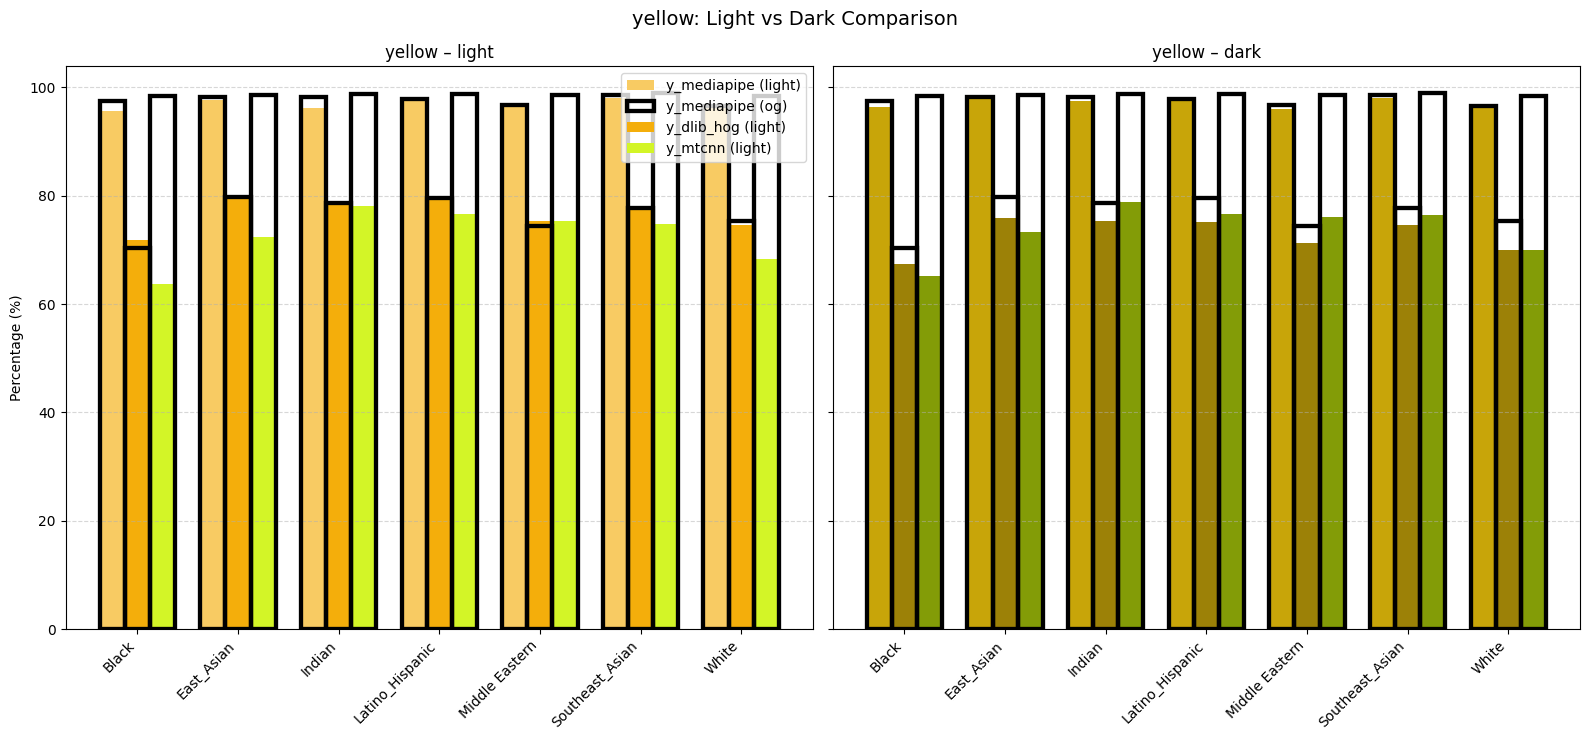

In [8]:
colorShadeComparison(df=df_fuse, col_name=['race'])

In [9]:
df_race = DfColorShade(df = df_fuse,col_name=['race'])
df_race = df_race.filter(like='diff')
df_race

,y_mediapipe_diff_yellow_dark,y_dlib_hog_diff_blue_light,y_dlib_hog_diff_yellow_light
0,-1.165462,0.704191,1.424812
1,-0.230814,-0.577034,-0.403924
2,-0.677966,-0.790960,0.338983
3,-0.304414,-0.761035,0.000000
4,-0.696056,0.309358,0.928074
5,-0.719424,-0.392413,0.130804
6,0.172043,-1.118280,-0.688172


### <h3 style="color:olive;"><b>5.3.2 - Gender </b></h3>

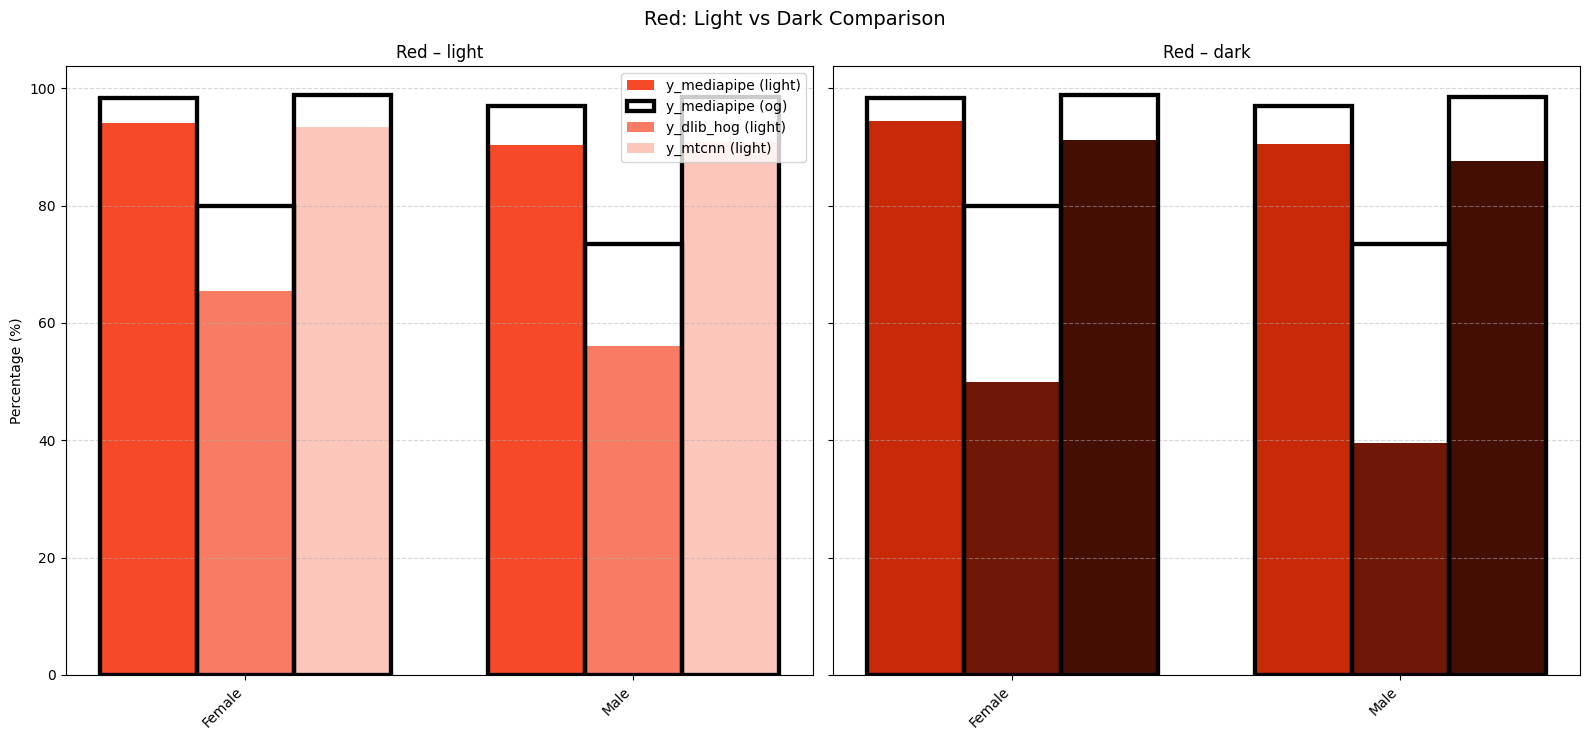

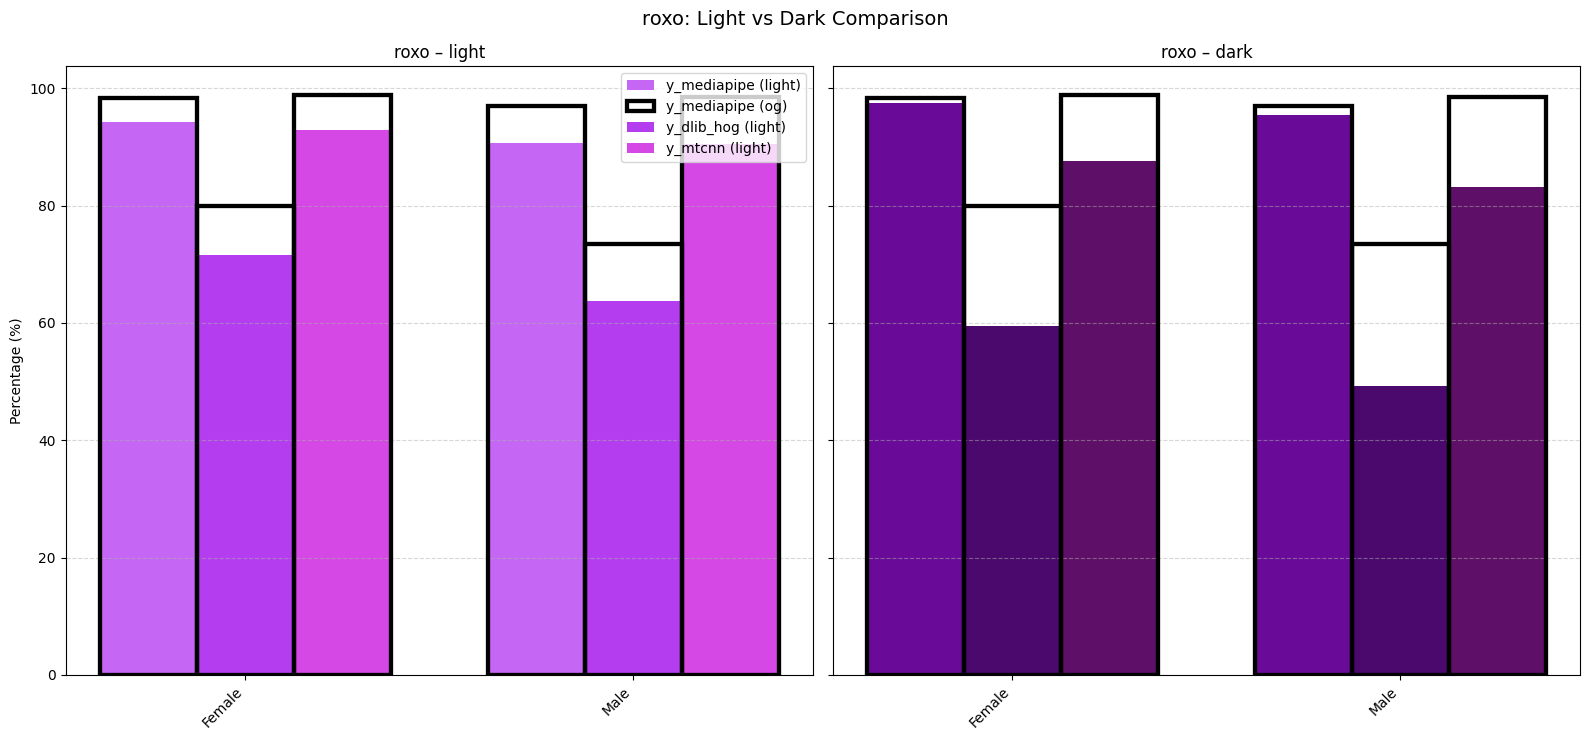

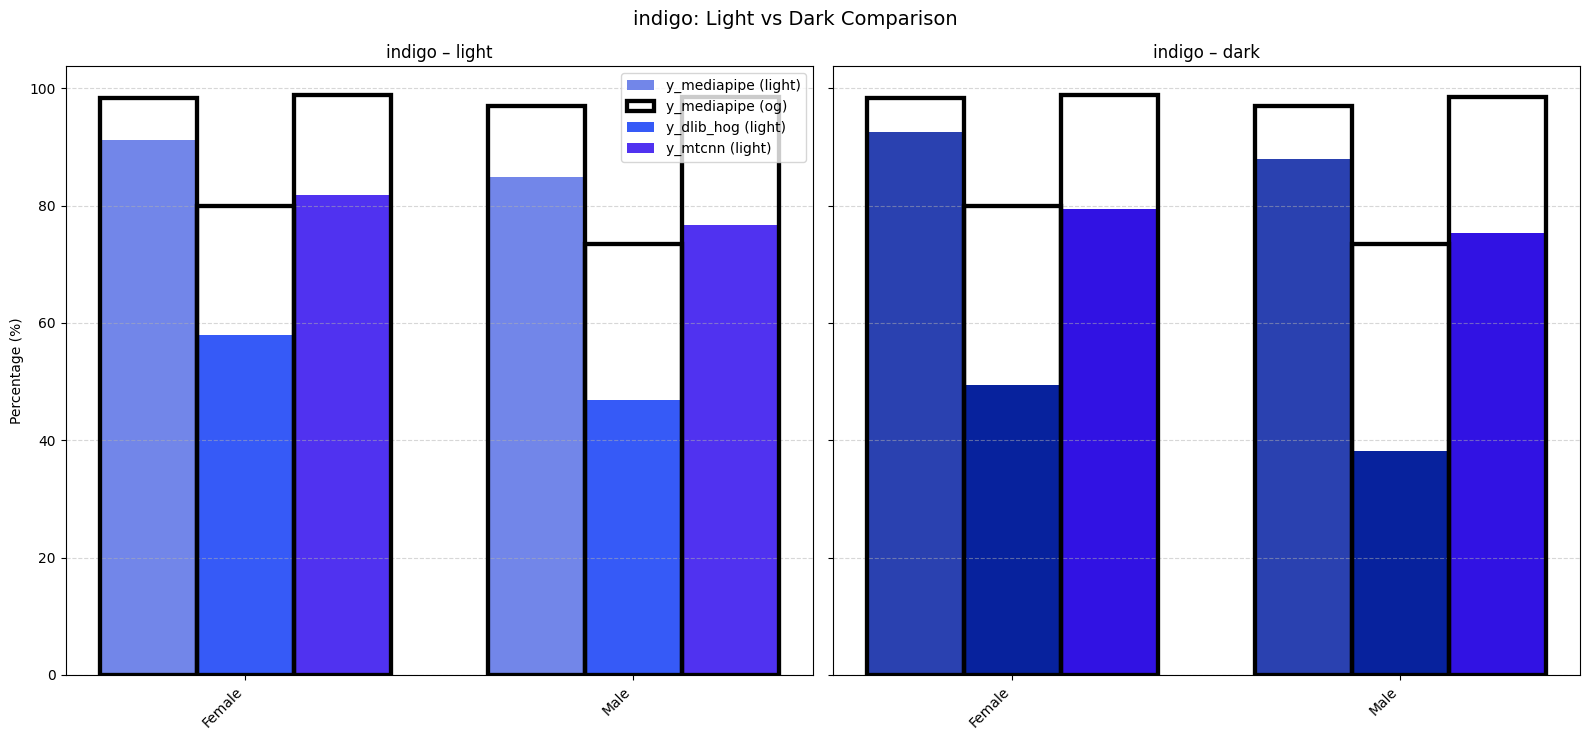

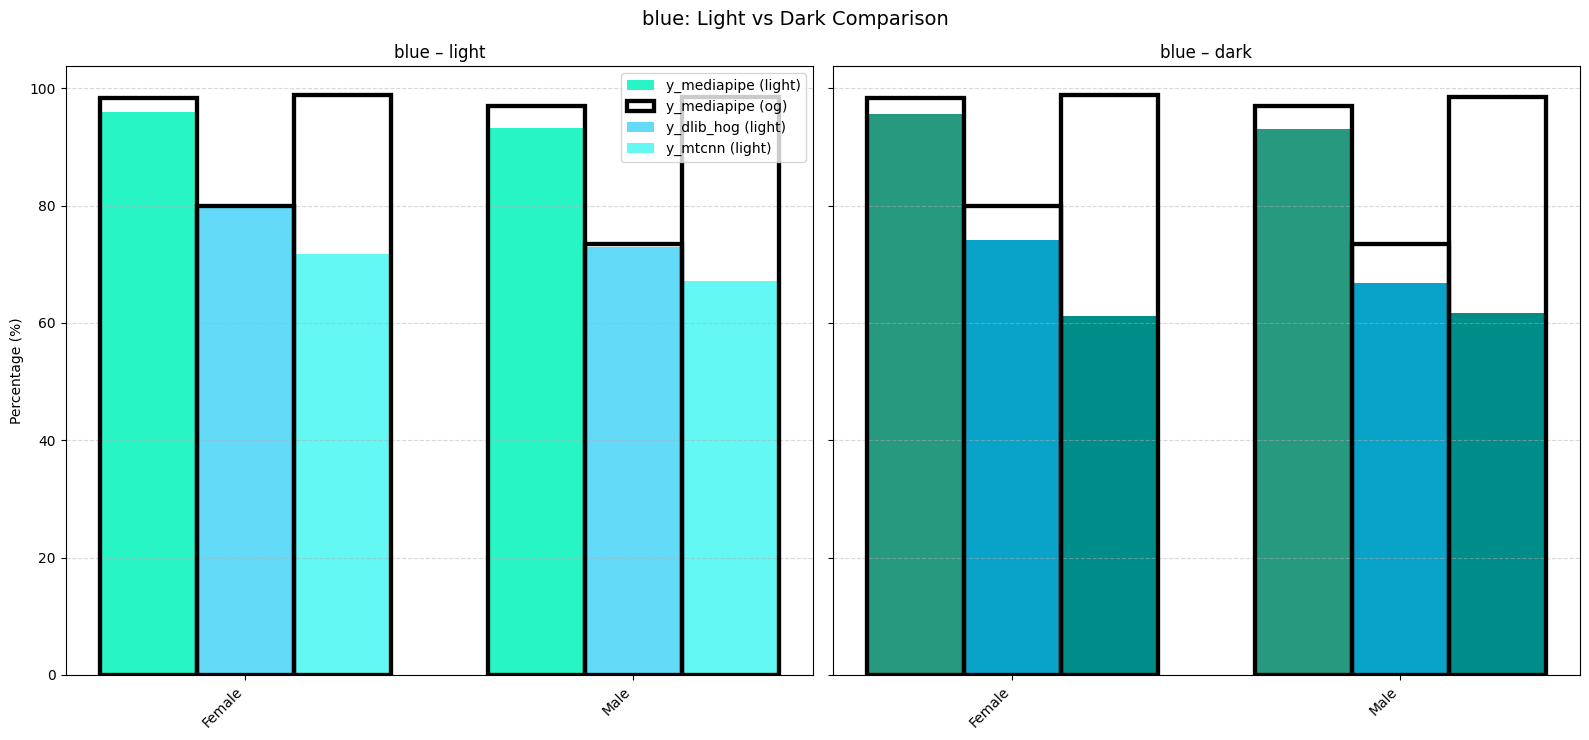

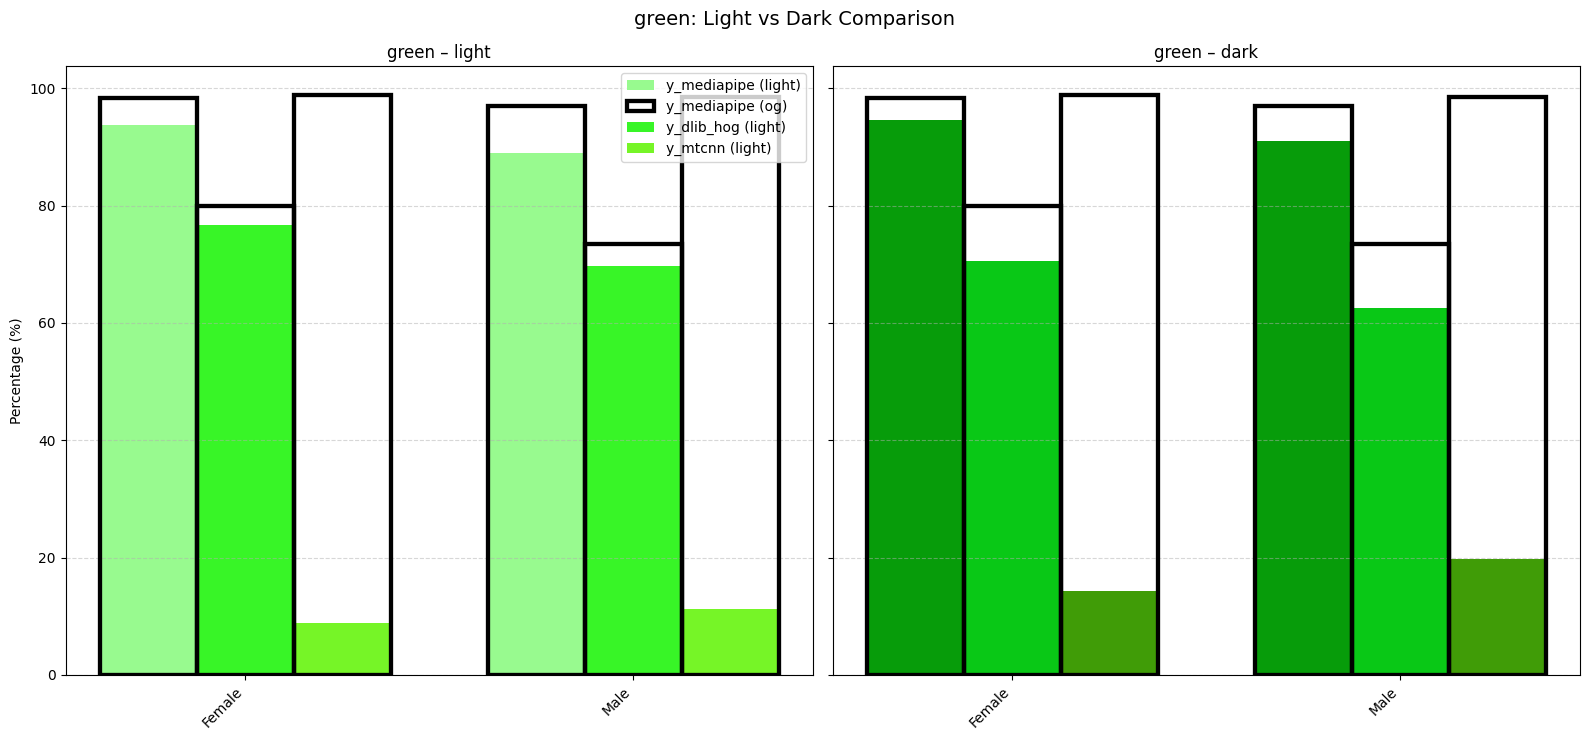

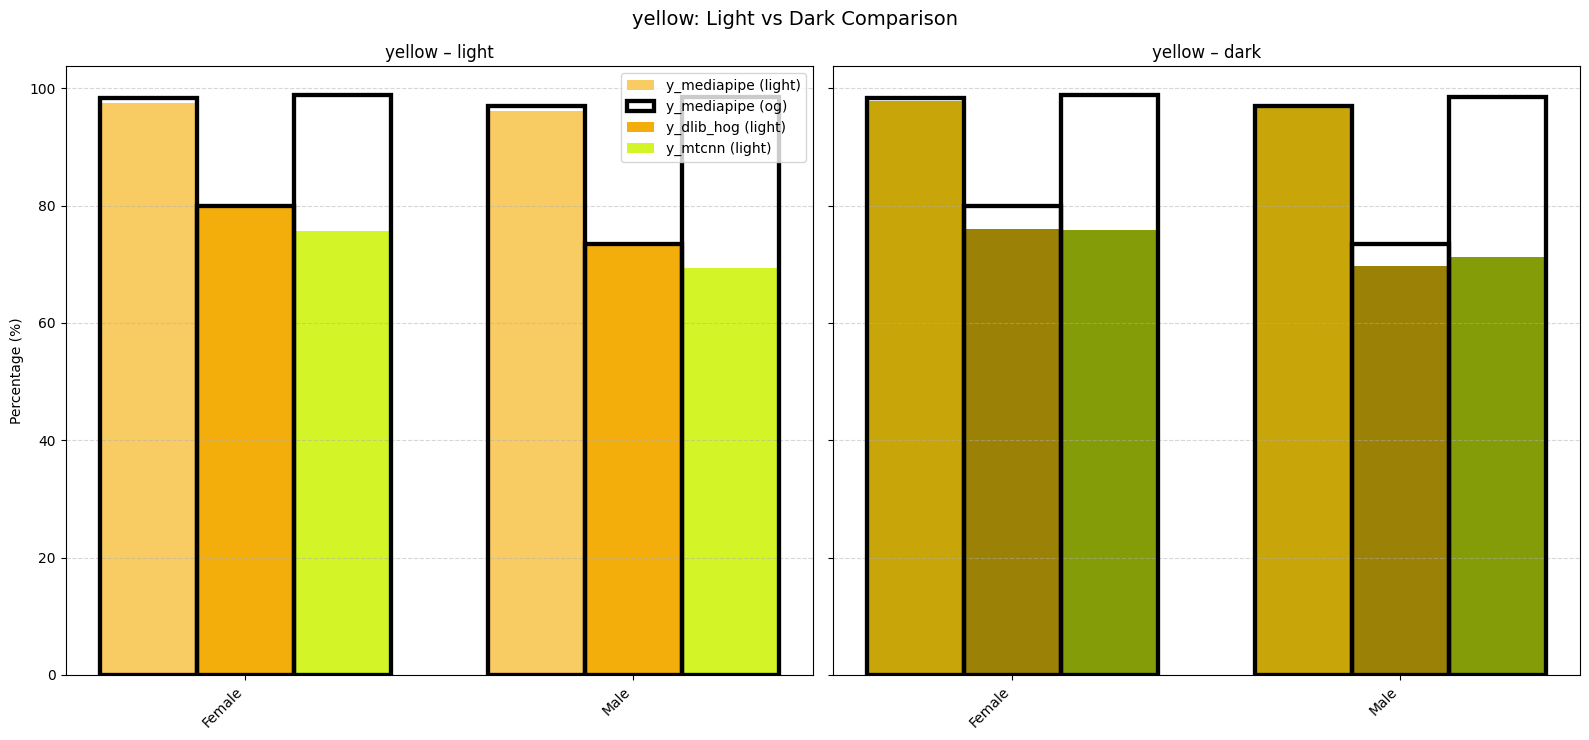

In [10]:
colorShadeComparison(df=df_fuse, col_name=['sex'])

In [11]:
df_gender = DfColorShade(df = df_fuse,col_name=['sex'])
df_gender = df_gender.filter(like='diff')
df_gender

,y_dlib_hog_diff_yellow_light
0,0.100067
1,0.260295


### <h3 style="color:olive;"><b>5.3.3 - Age </b></h3>

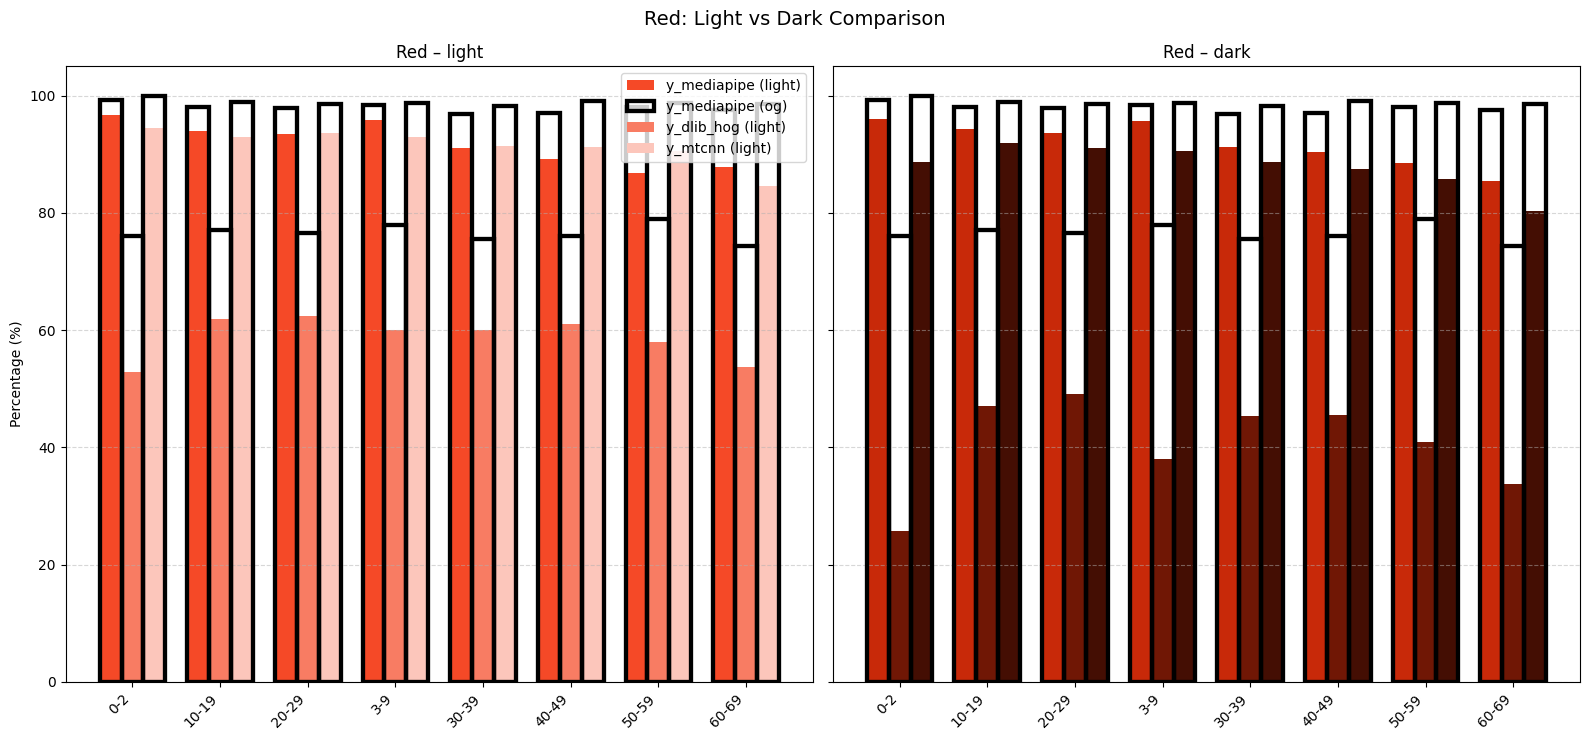

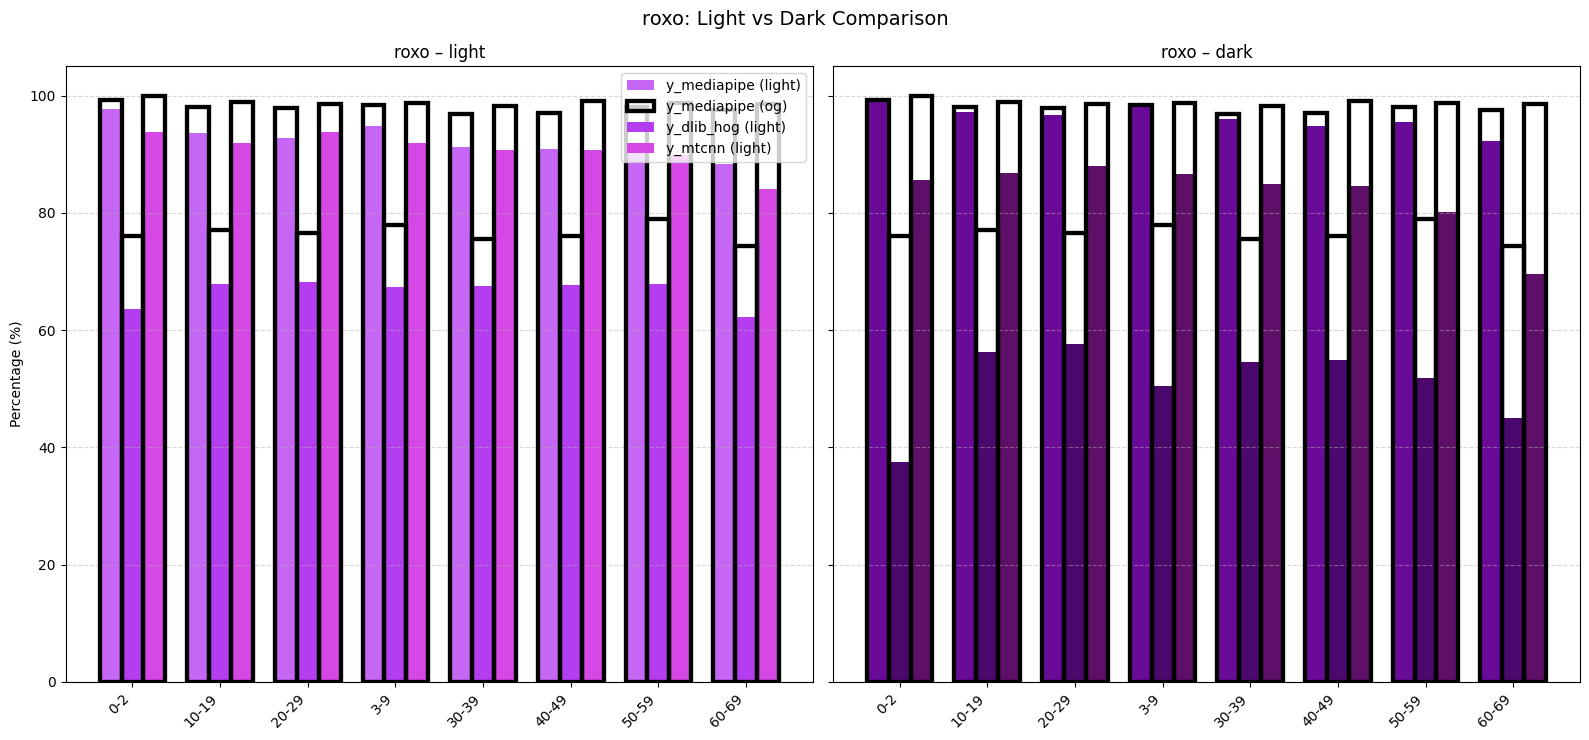

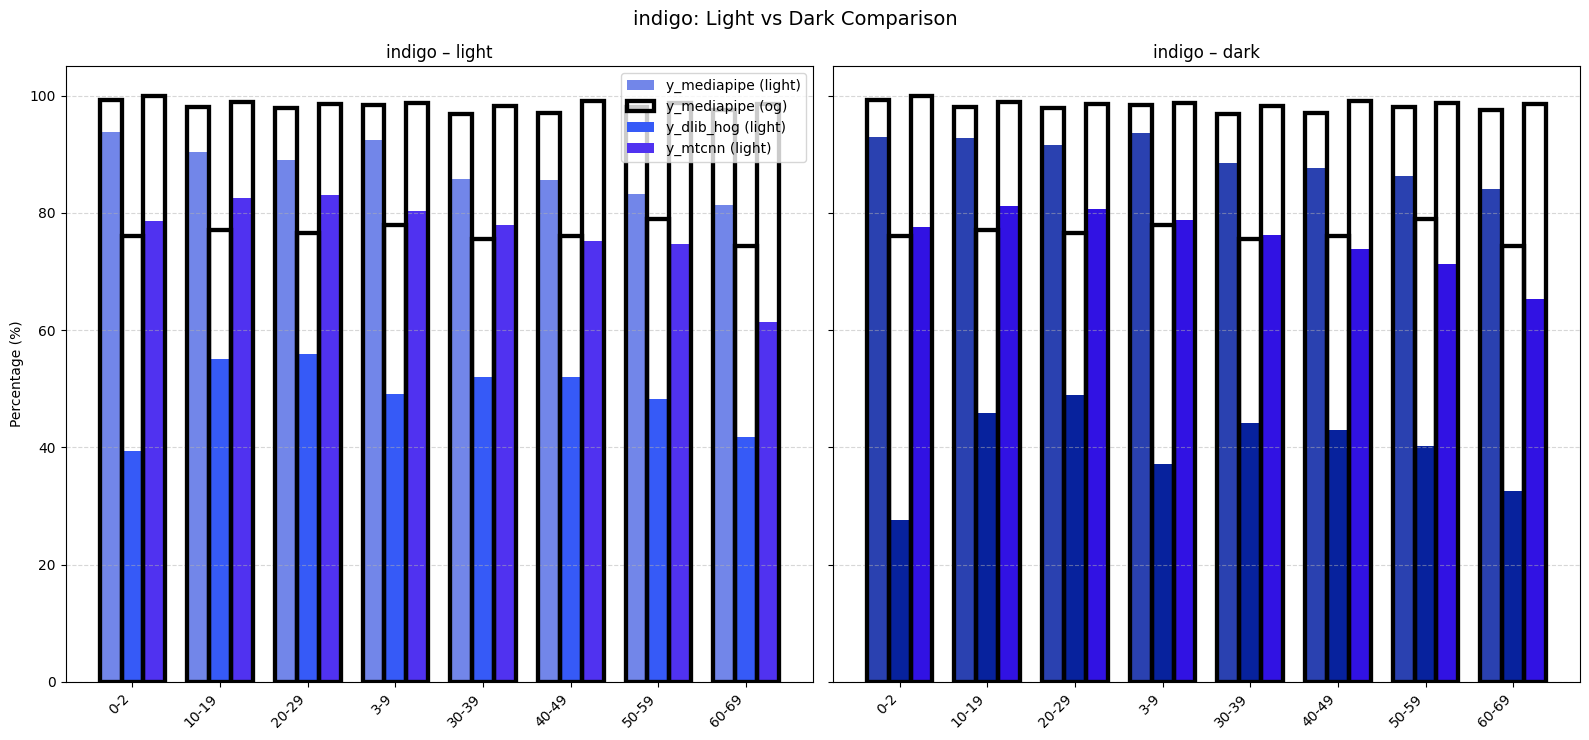

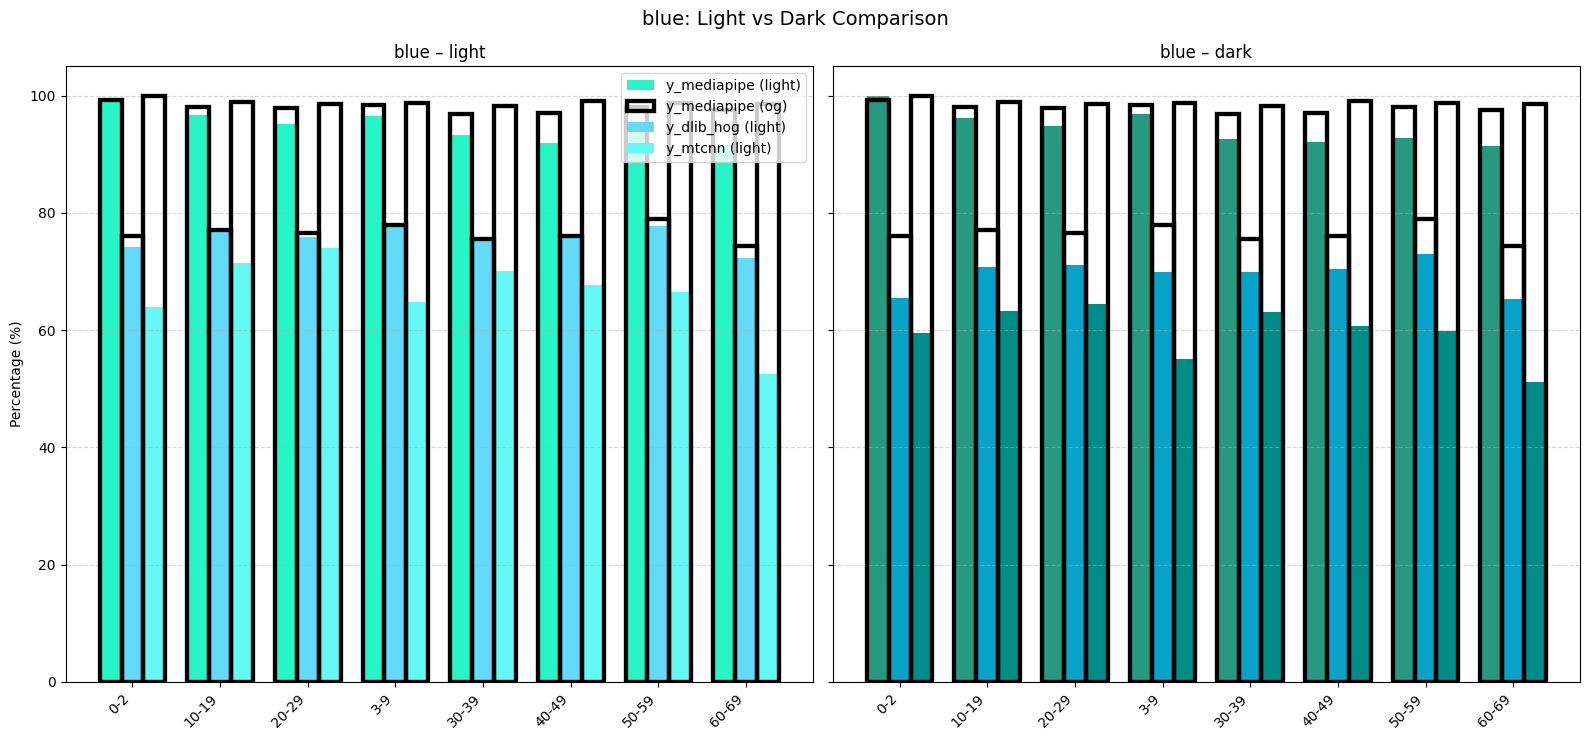

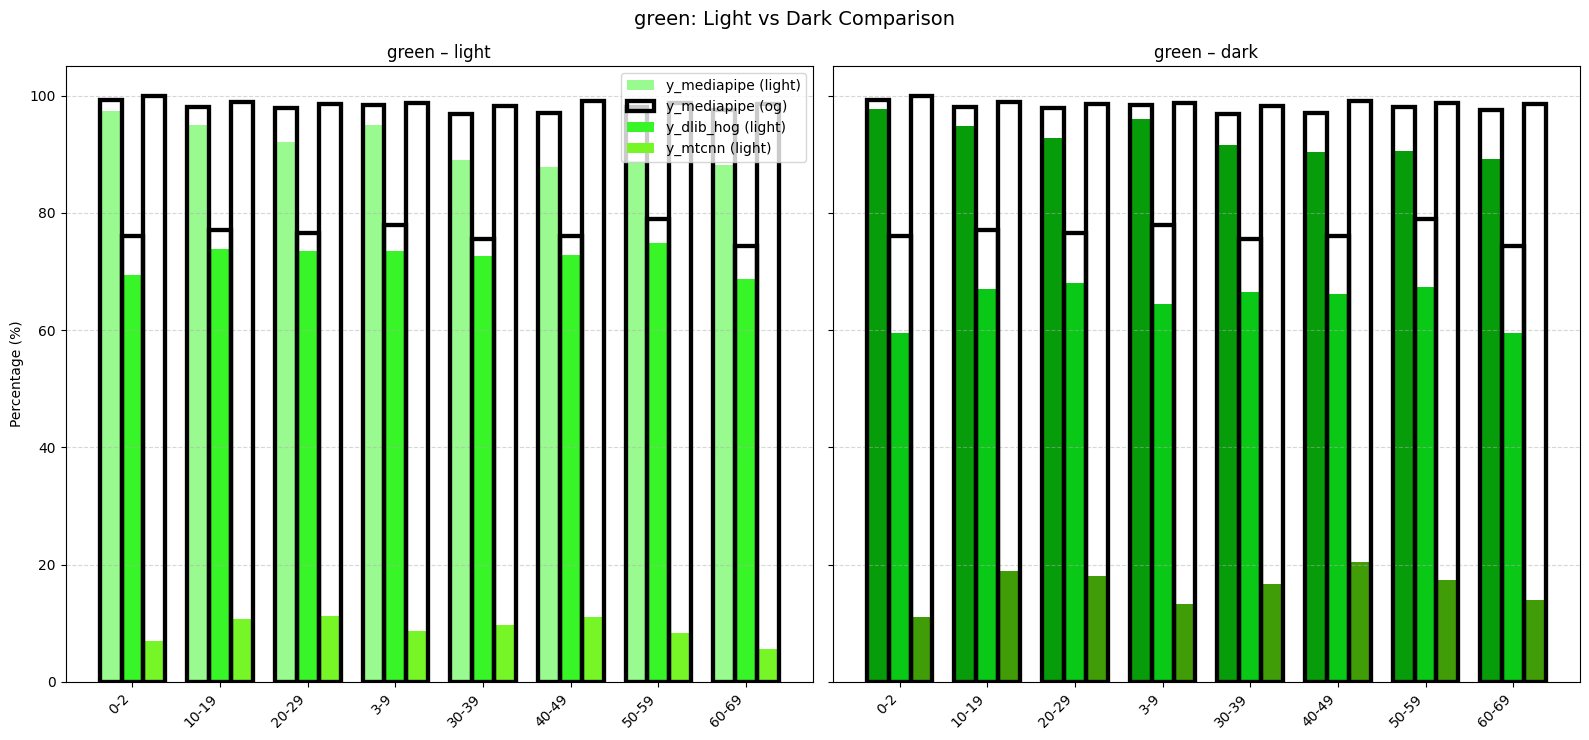

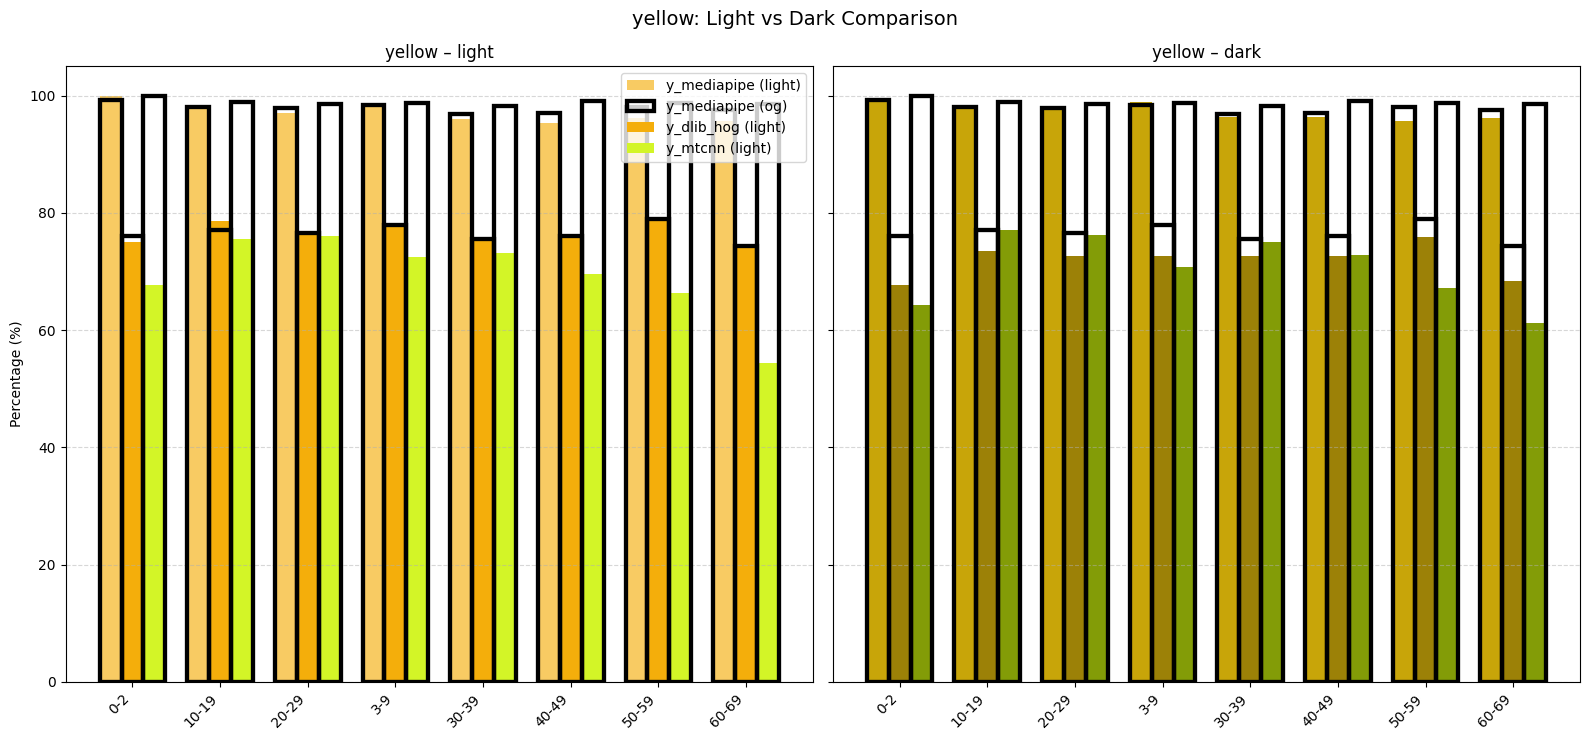

In [12]:
colorShadeComparison(df=df_fuse, col_name=['age'])

In [13]:
df_age = DfColorShade(df = df_fuse,col_name=['age'])
df_age = df_age.filter(like='diff')
df_age

,y_mediapipe_diff_blue_dark,y_mediapipe_diff_blue_light,y_mediapipe_diff_roxo_dark,y_mediapipe_diff_yellow_dark,y_mediapipe_diff_yellow_light,y_dlib_hog_diff_blue_light,y_dlib_hog_diff_yellow_light
0,0.735294,0.000000,0.000000,0.367647,0.735294,-1.838235,-1.102941
1,-1.811594,-1.304348,-0.797101,-0.289855,-0.362319,0.000000,1.449275
2,-3.043719,-2.656336,-1.217488,-0.387382,-0.913116,-0.747095,-0.193691
3,-1.597443,-1.852871,-0.128733,0.445980,-0.001019,-0.397242,0.177471
4,-4.292302,-3.653778,-0.922313,-0.603051,-0.957786,-0.177368,0.177368
5,-4.955265,-5.092911,-2.133517,-0.619408,-1.651755,0.412939,0.412939
6,-5.213270,-4.383886,-2.488152,-2.251185,-1.777251,-1.184834,-0.355450
7,-6.199461,-5.929919,-5.390836,-1.347709,-1.886792,-2.156334,0.269542


## <h2 style="color:olive;"><b>5.4 - Painted vs Original: generall comparison </b></h2>

In [14]:
df_all = DfColorShade(df = df_fuse,col_name=['age', 'sex', 'race'])
df_all = df_all.filter(like='diff')
df_all

,y_mediapipe_diff_Red_dark,y_mediapipe_diff_Red_light,y_mediapipe_diff_blue_dark,y_mediapipe_diff_blue_light,y_mediapipe_diff_green_dark,y_mediapipe_diff_green_light,y_mediapipe_diff_indigo_dark,y_mediapipe_diff_indigo_light,y_mediapipe_diff_roxo_dark,y_mediapipe_diff_roxo_light,...,y_dlib_hog_diff_roxo_light,y_dlib_hog_diff_yellow_dark,y_dlib_hog_diff_yellow_light,y_mtcnn_diff_Red_dark,y_mtcnn_diff_Red_light,y_mtcnn_diff_indigo_dark,y_mtcnn_diff_indigo_light,y_mtcnn_diff_roxo_dark,y_mtcnn_diff_roxo_light,y_mtcnn_diff_yellow_light
0,0.000000,-12.500000,0.000000,0.000000,-6.250000,-6.250000,-12.500000,-12.500000,0.000000,-6.250000,...,0.000000,0.000000,6.250000,-12.500000,-6.250000,-25.000000,-37.500000,-25.000000,-12.500000,-37.500000
1,-4.761905,-4.761905,0.000000,-4.761905,-4.761905,-4.761905,-4.761905,-4.761905,0.000000,0.000000,...,-9.523810,0.000000,0.000000,-14.285714,-4.761905,-28.571429,-19.047619,-19.047619,0.000000,-47.619048
2,-6.250000,-6.250000,0.000000,0.000000,0.000000,0.000000,-6.250000,-6.250000,-6.250000,-6.250000,...,-18.750000,-12.500000,0.000000,0.000000,0.000000,0.000000,-6.250000,-6.250000,-6.250000,-18.750000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-14.285714,-7.142857,-7.142857,-7.142857,0.000000,-28.571429,-7.142857,-14.285714,0.000000,-14.285714
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-50.000000,-50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,-29.166667,-20.833333,-16.666667,-12.500000,-25.000000,-20.833333,-16.666667,-37.500000,-12.500000,-20.833333,...,-12.500000,-4.166667,4.166667,-25.000000,-12.500000,-41.666667,-58.333333,-45.833333,-20.833333,-70.833333
108,-7.142857,-9.523810,-2.380952,-7.142857,-7.142857,-7.142857,-2.380952,-11.904762,-4.761905,-4.761905,...,-9.523810,-9.523810,2.380952,-14.285714,-7.142857,-45.238095,-40.476190,-28.571429,-14.285714,-33.333333
109,-13.461538,-7.692308,-5.769231,-5.769231,-5.769231,-9.615385,-19.230769,-15.384615,-9.615385,-17.307692,...,-13.461538,-7.692308,1.923077,-23.076923,-17.307692,-32.692308,-30.769231,-32.692308,-13.461538,-53.846154
110,-5.263158,0.000000,0.000000,0.000000,0.000000,-5.263158,-10.526316,-5.263158,0.000000,0.000000,...,-15.789474,-10.526316,0.000000,-21.052632,-21.052632,-47.368421,-47.368421,-21.052632,-15.789474,-42.105263


---
# <h1 style="color:olive;"><b> 6 - General Takeaway </b></h1>

---

# <h1 style="color:#89F3EA;"><b>7 - EXTRA/FAILURES AND IMPRVMENTS </b></h1>

for facial features (try to eval based on shape of: nose, lips, yeys, chin,...)

on the failed imgs, which ones wher more commonly faled and why they failed (where parts in specific?, lv of confidence)